In [1]:
from google.colab import drive
import os
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from scipy.stats import kurtosis, skew, jarque_bera
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kurtosistest, skewtest, jarque_bera

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
drive.mount('/content/drive')
shared_folder_path = '/content/drive/My Drive/proyecto_series_de_tiempo'
files = os.listdir(shared_folder_path)
print(files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['bitcoin_data_raw.parquet', '723732BTC-USD.csv', 'Proyecto Series de Tiempo.ipynb']


# Ejercicio 1

## Análisis Exploratorio de Datos 25 %
Considere la serie de tiempo asociada con el Proyecto Final de Series de Tiempo. Realice un
Análisis Exploratorio de Datos (EDA) considerando cada una de las metodologías abordadas
durante el curso. Es crucial en este primer ejercicio que cada figura descriptiva, tabla o resumen
de resultados, cuente con su respectiva interpretación.

### • Utilice la API de Yahoo Finance para obtener el dataset asociado con el proyecto final, a saber BTC-USD

In [ ]:
# ticker = 'BTC-USD'
# bitcoin_data = yf.download(ticker, start='2010-01-01')  # Start date can be adjusted as needed

# # Rename columns for consistency
# bitcoin_data.rename(columns={
#     'Open': 'open',
#     'High': 'high',
#     'Low': 'low',
#     'Close': 'close',
#     'Adj Close': 'adj_close',
#     'Volume': 'volume'
# }, inplace=True)
# bitcoin_data.to_parquet(os.path.join(shared_folder_path, 'bitcoin_data_raw.parquet'))

Continuamos con un datset que continen los precios historicos y volumnes del
**2014-09-17 a 2024-05-16**

### • Identifique si existen datos faltantes y realice su imputación de la forma más adecuada.

Procedemos a verificar que los datos no tengan nullos o NaNs. Además que no hayan días faltantes en el dataset.

In [ ]:
btc = pd.read_parquet(os.path.join(shared_folder_path, 'bitcoin_data_raw.parquet'))

In [ ]:
btc.head()

open        high         low       close   adj_close  \
Date                                                                     
2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

              volume  
Date                  
2014-09-17  21056800  
2014-09-18  34483200  
2014-09-19  37919700  
2014-09-20  36863600  
2014-09-21  26580100

### **Análisis Exploratorio de Datos:**

En esta sección se obtendrán ciertas informaciones necesarias para lograr implementar los modelos y además poder tener una idea clara del comportamiento de nuestro conjunto de datos.

In [ ]:
btc.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

Lo siguiente muestra que no hay ningun dato faltante en nuestro dataset, por lo tanto no tendremos que recurrir a metodologias de imputacion de datos faltantes

In [ ]:
min_date = btc.index.min()
max_date = btc.index.max()
date_range = pd.date_range(start=min_date, end=max_date)
missing_dates = set(date_range) - set(btc.index)
print(f"Fechas faltantes: {missing_dates}" if missing_dates else f"No hay fechas faltantes de {min_date} a {max_date}")

No hay fechas faltantes de 2014-09-17 00:00:00 a 2024-05-16 00:00:00


### • Realice un gráfico de velas utilizando la librería Plotly para la serie de tiempo (Close BTCUSD). Realice también un histograma con Plotly para representar el volumen tradeado diariamente (Volume)

In [ ]:
import plotly.graph_objects as go

figure = go.Figure(data=[go.Candlestick(x=btc.index,
                open=btc['open'],
                high=btc['high'],
                low=btc['low'],
                close=btc['close'])])

figure.update_layout(title=f'Candlestick Chart of Bitcoin Prices Days',
                  xaxis_title='Date',
                  yaxis_title='Price (USD)')

figure.show()


Del anterior diagrama de velas se puede observar que el comportamiento del activo Bitcoin no sigue una tendencia estable a lo largo del tiempo. Sin embargo, a mediados del año 2021 se puede observar un aumento significativo en el precio. Luego de indagar, estas pueden ser una de las posibles causas

1. Auge de las billeteras digitales y la modernizacion de los Non Fudgible Tokens 💰
2.  Adopcion abierta en algunos paises del Bitcoin (El Salvador, China, India)
3.  Aunque estemos hablando de activos muy volátiles han mantenido un incremento en su valor vs las monedas fiat ✅




In [ ]:
figure = go.Figure(data=[go.Histogram(x=btc['volume'])])

figure.update_layout(title='Histogram of Daily Traded Volume',
                  xaxis_title='Volume',
                  yaxis_title='Frequency')

figure.show()


*Un mayor volumen de trading suele traducirse en un mercado más activo, mientras que un volumen más ligero suele indicar un mercado menos activo, o inactivo.*

Por lo tanto, de la anterior grafica podemos deducir que el volumen de Bitcoin tiene una actividad alta comparado con otros activos mas convencionales. Sin embargo, hay un dato que llama la atencion, que es aquel con un volumen de 35OB, veamos en que momento ocurrio esta observacion

In [ ]:
volume_chart = go.Figure(data=[go.Bar(x=btc.index,
                                      y=btc['volume'],
                                      marker=dict(color='blue'),
                                      name='Volume')])

volume_chart.update_layout(
    title=f'Volume of BTC-USD Trades',
    xaxis_title='Date',
    yaxis_title='Volume',
    template='plotly_white'
)

volume_chart.show()

A partir del anterior grafico vemos que a última vez que su precio escaló a un máximo histórico fue en noviembre de 2021, pero a los pocos meses después se hundió a US$16.500.

Esto es una explicacion formidable al incremento de volumen durante esta temporada  La caída de Bitcoin, de cerca de 65.000 dólares en abril de 2021 a alrededor de 21.000 dólares a mediados de junio, fue en gran parte una respuesta a la represión de China contra la minería de Bitcoin .

### • Realice gráficos de subseries considerando agrupación por semana, mes y año. Utilice gráficos de series de tiempo y boxplots para analizar estas subseries.

La tendencia de una serie temporal se modela comúnmente mediante una regresión respecto al tiempo y otras variables conocidas como explicativas.

**Motivos de uso:**
- Esta regresión se usa para predecir el movimiento a largo plazo de la serie. Los residuos de esta regresión revelan otras características como:

1.  ✅  La estacionalidad,
2.  ✅  Ciclos
3.  ✅  Variaciones irregulares.

In [ ]:
from sklearn.linear_model import LinearRegression
trend_model = LinearRegression(fit_intercept=True)
trend_model.fit(np.arange(btc.close.shape[0]).reshape((-1,1)), btc.close)

LinearRegression()

In [ ]:
print('Trend model coefficient={} and intercept={}'.format(trend_model.coef_[0], trend_model.intercept_))

Trend model coefficient=13.935307286800128 and intercept=-8348.244904282225


In [ ]:
residuals = np.array(btc.close) - trend_model.predict(np.arange(btc.close.shape[0]).reshape((-1,1)))

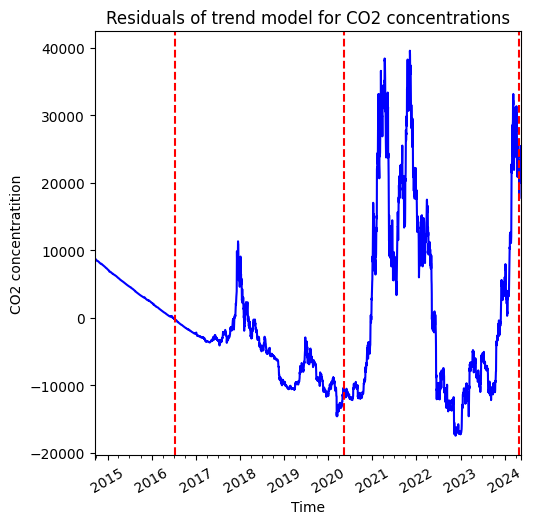

In [ ]:
plt.figure(figsize=(5.5, 5.5))
pd.Series(data=residuals, index=btc.index).plot(color='b')
plt.title('Residuals of trend model for CO2 concentrations')
plt.xlabel('Time')
plt.ylabel('CO2 concentratition')
plt.xticks(rotation=30);

# Halving dates
halving_dates = [
    '2012-11-28', '2016-07-09', '2020-05-11', '2024-05-01'
]

for date in halving_dates:
    plt.axvline(x=date, color='r', linestyle='--')

La anterior muestra variaciones repetitivas y periódicas durante nuestra serie temporal (delimitadas con linea roja) y nos resulta de gran interes. Luego de indagar, pudimos averiguar la influencia de los _**halvings**_ de bitcoin.

Estos eventos son importantes para los inversores porque reducen el número de bitcoins nuevos que genera la red. Esto limita la oferta de nuevas monedas, por lo que los precios podrían subir si la demanda se mantiene alta.

In [ ]:
residuals = pd.Series(data=residuals, index=btc.index)

In [ ]:
residuals

Date
2014-09-17     8805.578919
2014-09-18     8758.749599
2014-09-19     8715.170280
2014-09-20     8715.342974
2014-09-21     8691.324690
                  ...     
2024-05-12    20674.681250
2024-05-13    22113.800630
2024-05-14    20751.205166
2024-05-15    25451.972984
2024-05-16    24314.377520
Length: 3530, dtype: float64

In [ ]:
btc['residuals'] = residuals

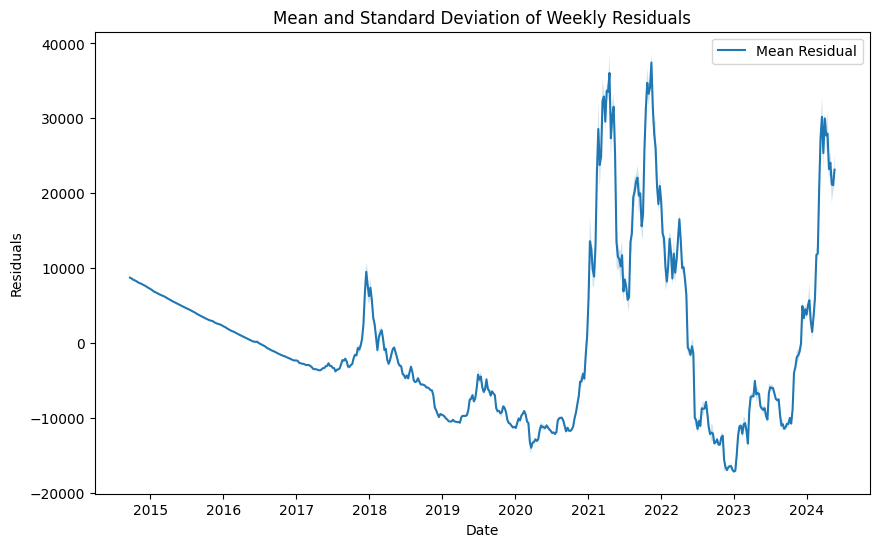

In [ ]:
weekly_btc = btc.groupby(pd.Grouper(freq='W')).agg(
    mean_residual=('residuals', 'mean'),
    std_residual=('residuals', 'std')
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(weekly_btc.index, weekly_btc['mean_residual'], label='Mean Residual')
ax.fill_between(weekly_btc.index, weekly_btc['mean_residual'] - weekly_btc['std_residual'],
                weekly_btc['mean_residual'] + weekly_btc['std_residual'], alpha=0.2)

ax.set_title('Mean and Standard Deviation of Weekly Residuals')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.legend()

plt.show()

La anterior grafica muestra una gran variabilidad a lo largo de las semanas del activo de Bitcoin. Tal como se espera de una activo con gran volatilidad, es dificil capturar adecuadamente la relación entre las variables o si hay algún patrón sistemático en las observaciones.

Sin embargo, resultaria interesante ver como se comportan los residuos del activo a lo largo de otras agrupaciones tales como mes y año

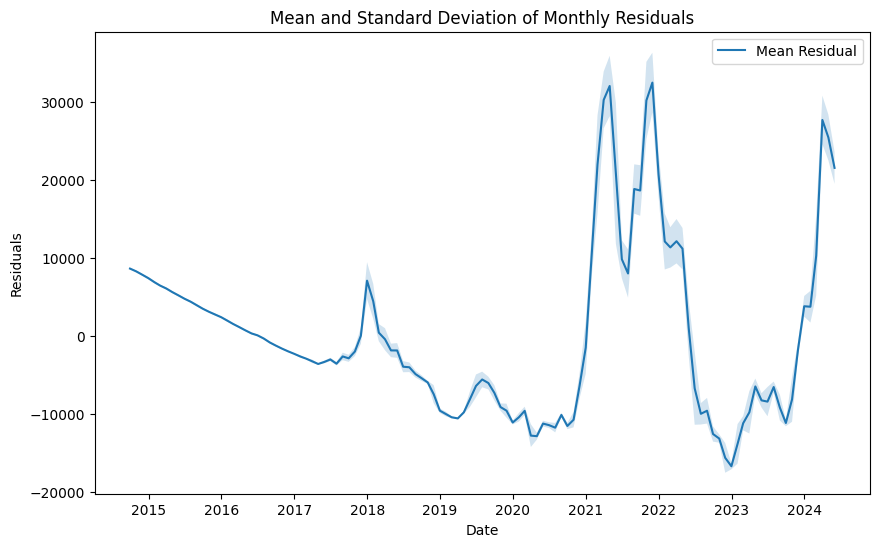

In [ ]:
monthly_btc = btc.groupby(pd.Grouper(freq='M')).agg(
    mean_residual=('residuals', 'mean'),
    std_residual=('residuals', 'std')
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(monthly_btc.index, monthly_btc['mean_residual'], label='Mean Residual')
ax.fill_between(monthly_btc.index, monthly_btc['mean_residual'] - monthly_btc['std_residual'],
                monthly_btc['mean_residual'] + monthly_btc['std_residual'], alpha=0.2)

ax.set_title('Mean and Standard Deviation of Monthly Residuals')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.legend()

plt.show()



Al momento de agrupar por meses los residuos. Podemos ver una suavizacion mas pronunciada de la serie. Aun asi, no existen patrones claros ya que son bastante irregulares y por lo tanto no podemos brindar garantias que nos permitan predecir el movimiento a lo largo de la serie

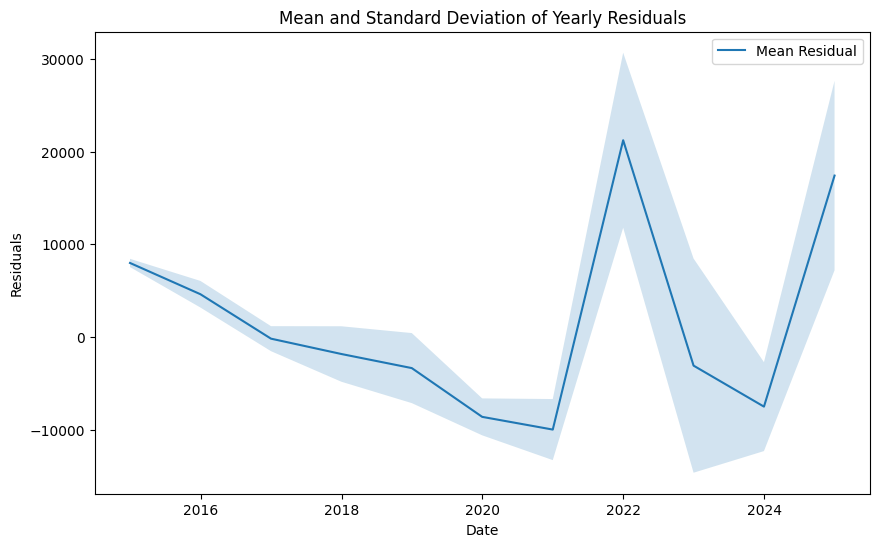

In [ ]:
yearly_btc = btc.groupby(pd.Grouper(freq='Y')).agg(
    mean_residual=('residuals', 'mean'),
    std_residual=('residuals', 'std')
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(yearly_btc.index, yearly_btc['mean_residual'], label='Mean Residual')
ax.fill_between(yearly_btc.index, yearly_btc['mean_residual'] - yearly_btc['std_residual'],
                yearly_btc['mean_residual'] + yearly_btc['std_residual'], alpha=0.2)

ax.set_title('Mean and Standard Deviation of Yearly Residuals')
ax.set_xlabel('Date')
ax.set_ylabel('Residuals')
ax.legend()

plt.show()



Este grafico nos permite interpretar la reduccion del precio del activo del 2014 al 2021 de una manera controlada, sin embargo, en el transcurso del año 2021 se nota el incremento del precio del activo, cuyas posibles razones fueron anteriormente mencionadas. Cabe recalcar, que a pesar del decaimiento del precio del activo en los años posteriores, a lo largo del año presente se ha presentado un incremento que pueda ser causado por el evento del Halving

In [ ]:
btc

open          high           low         close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2024-05-12  60793.503906  61818.156250  60632.601562  61448.394531   
2024-05-13  61451.218750  63422.660156  60769.839844  62901.449219   
2024-05-14  62900.773438  63092.125000  61123.765625  61552.789062   
2024-05-15  61553.988281  66454.453125  61330.410156  66267.492188   
2024-05-16  66253.937500  66591.296875  64678.179688  65143.832031   

               adj_close       volume     residuals  
Date                                                 
2014-09-17    457.334015     21056800   8805.578919  
2014-09-18    424.440002     34483200   8758.749599  
2014-09-19    394.795990     37919700   8715.170280  
2014-09-20    408.903992     36863600   8715.342974  
2014-09-21    398.821014     26580100   8691.324690  
...                  ...          ...           ...  
2024-05-12  61448.394531  13800459405  20674.681250  
2024-05-13  62901.449219  27889181179  22113.800630  
2024-05-14  61552.789062  28186271527  20751.205166  
2024-05-15  66267.492188  39815167074  25451.972984  
2024-05-16  65143.832031  33335959552  24314.377520  

[3530 rows x 7 columns]

In [ ]:
btc

open          high           low         close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2024-05-12  60793.503906  61818.156250  60632.601562  61448.394531   
2024-05-13  61451.218750  63422.660156  60769.839844  62901.449219   
2024-05-14  62900.773438  63092.125000  61123.765625  61552.789062   
2024-05-15  61553.988281  66454.453125  61330.410156  66267.492188   
2024-05-16  66253.937500  66591.296875  64678.179688  65143.832031   

               adj_close       volume     residuals  
Date                                                 
2014-09-17    457.334015     21056800   8805.578919  
2014-09-18    424.440002     34483200   8758.749599  
2014-09-19    394.795990     37919700   8715.170280  
2014-09-20    408.903992     36863600   8715.342974  
2014-09-21    398.821014     26580100   8691.324690  
...                  ...          ...           ...  
2024-05-12  61448.394531  13800459405  20674.681250  
2024-05-13  62901.449219  27889181179  22113.800630  
2024-05-14  61552.789062  28186271527  20751.205166  
2024-05-15  66267.492188  39815167074  25451.972984  
2024-05-16  65143.832031  33335959552  24314.377520  

[3530 rows x 7 columns]

In [ ]:
import plotly.subplots as sp

btc['year'] = btc.index.year

# Create a grid of subplots
fig = sp.make_subplots(rows=3, cols=4, subplot_titles=("2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023", "2024", "2025"))

# Iterate over each year and create a box plot for each year's data
for i, year in enumerate(btc['year'].unique()):
    year_data = btc[btc['year'] == year]['close']
    fig.add_trace(go.Box(y=year_data), row=i // 4 + 1, col=i % 4 + 1)

# Update the layout and show the plot
fig.update_layout(height=1000, width=1200, title="Box Plots of Yearly Closing Prices")
fig.show()


Es evidente a lo largo de los diagramas de cajas que la media del precio de cierre a lo largo de los años es diferente. Ademas en los años 2015, 2017, 2020, 2023 hay bastante presencia de valores atipicos, posibles causas de esto pueden ser los diferentes eventos que han surgido en torno a la adopcion del bitcoin en plataformas como internet, bancos y plataformas de pago.

Obviamente, tambien se puede ver la variabilidad del precio medio a lo largo de los años. Una posible causa de este suceso es que las criptomonedas desde su llegada han mantenido un incremento en su valor vs las monedas fiat, es decir, si analizamos el valor promedio a largo plazo siempre será positivo el balance.

Por razones practicas hicimos esta agrupacion por años, ya que, de cualquier otro modo fuesen muchas cajas las que habria que interpretar y dificultaria la visualizacion

### • Estudie estacioanriedad de la serie de tiempo usando la ACF estudiada durante el curso, así como también los respectivos test estadísticos tales como Ljung-Box y Dickey Fuller. Aplique además transformación logaritmica, para convertir la serie de tiempo en estacionaria.

In [ ]:
lag = range(0, 365)
btc_acf = []
for l in lag:
    btc_acf.append(btc['close'].autocorr(l))

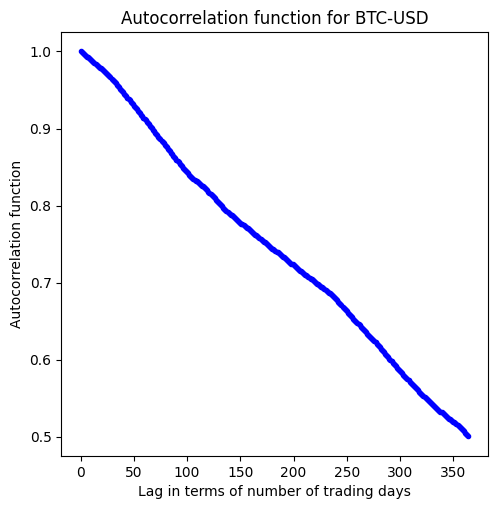

In [ ]:
plt.figure(figsize=(5.5, 5.5))
plt.plot(btc_acf, marker='.', color='b')
plt.title('Autocorrelation function for BTC-USD')
plt.xlabel('Lag in terms of number of trading days')
plt.ylabel('Autocorrelation function');

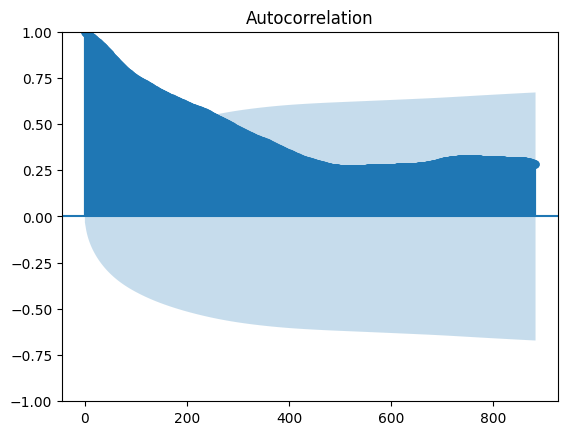

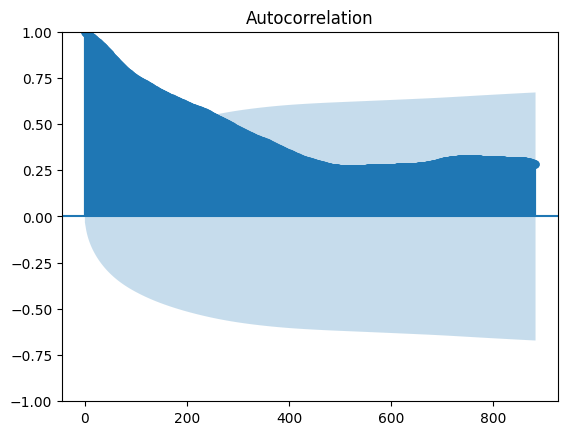

In [ ]:
# Fix why is printing two graphs
plot_acf(btc['close'], lags=882)

El numero de lags que se implemento para el grafico fue calculado a partir de la formula sugerida en clase de T/4. En ese orden de ideas, viendo el anterior grafico vemos que aproximadamente las primeras 200 muestras son estadisticamente significativas, lo que sugiere una alta correlacion entre las mismas. En otras palabras, cuando el precio de BTC aumente tiende a seguir subiendo y cuando el precio de BTC baje, tiende a seguir bajando
Sin embargo, puede resultar un analisis mas interesante ver que tal se comportan los retornos diarios ya que es posible tener otras interpretaciones donde podamos determinar si los retornos estan correlacionados

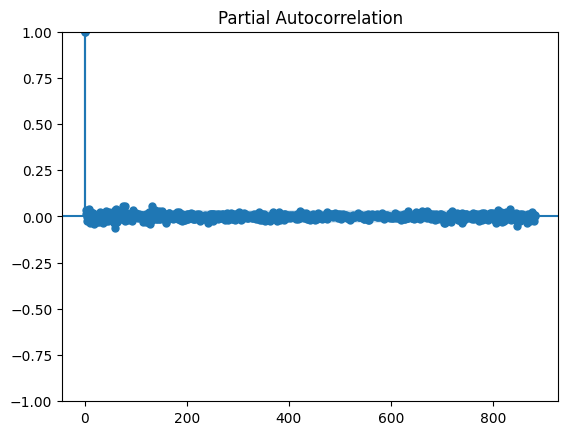

In [ ]:
plot_pacf(btc['close'], lags=883);

En cambio, el gráfico PACF muestra la correlación parcial de la serie con sus propios valores retardados, controlando los valores de la serie temporal en todos los retardos más cortos. Esto significa que el PACF ilustra el efecto directo de los valores pasados sobre el valor actual, sin la influencia de los valores intermedios

In [ ]:
from statsmodels.tsa import stattools
acf_btc, confint_btc, qstat_btc, pvalues_btc = stattools.acf(btc['close'],
                                                                 nlags=365,
                                                                 qstat=True,
                                                                 alpha=0.05)

In [ ]:
alpha = 0.05
for l, p_val in enumerate(pvalues_btc):
    if p_val > alpha:
        print('Null hypothesis is accepted at lag = {} for p-val = {}'.format(l, p_val))
    else:
        print('Null hypothesis is rejected at lag = {} for p-val = {}'.format(l, p_val))

Null hypothesis is rejected at lag = 0 for p-val = 0.0
Null hypothesis is rejected at lag = 1 for p-val = 0.0
Null hypothesis is rejected at lag = 2 for p-val = 0.0
Null hypothesis is rejected at lag = 3 for p-val = 0.0
Null hypothesis is rejected at lag = 4 for p-val = 0.0
Null hypothesis is rejected at lag = 5 for p-val = 0.0
Null hypothesis is rejected at lag = 6 for p-val = 0.0
Null hypothesis is rejected at lag = 7 for p-val = 0.0
Null hypothesis is rejected at lag = 8 for p-val = 0.0
Null hypothesis is rejected at lag = 9 for p-val = 0.0
Null hypothesis is rejected at lag = 10 for p-val = 0.0
Null hypothesis is rejected at lag = 11 for p-val = 0.0
Null hypothesis is rejected at lag = 12 for p-val = 0.0
Null hypothesis is rejected at lag = 13 for p-val = 0.0
Null hypothesis is rejected at lag = 14 for p-val = 0.0
Null hypothesis is rejected at lag = 15 for p-val = 0.0
Null hypothesis is rejected at lag = 16 for p-val = 0.0
Null hypothesis is rejected at lag = 17 for p-val = 0.0
Nu

In [ ]:
# Dickey Fuller Test
adf_result = stattools.adfuller(btc['close'], autolag='AIC')

In [ ]:
print('p-val of the ADF test in BTC close price:', adf_result[1])

p-val of the ADF test in BTC close price: 0.8220396477574012


Lo anterior indica que aceptamos la hipotesis nula. Por lo tanto, nuestra serie de tiempo no es estacionaria. Como era de esperarse, ya que la varianza en este tipo de activos no se mantiene constante a lo largo de las observaciones y es posible determinar que factores como la tendencia y/o variabilidad cambian en el tiempo. Los cambios en la media determinan una tendencia a crecer o decrecer a largo plazo, por lo que la serie no oscila alrededor de un valor constante.

In [ ]:
# Transformación Logaritmica (sin multiplicar por 100)

btc_dr = (btc['close'] - btc['close'].shift(1)) / btc['close'].shift(1)
btc_dr.dropna(inplace=True)


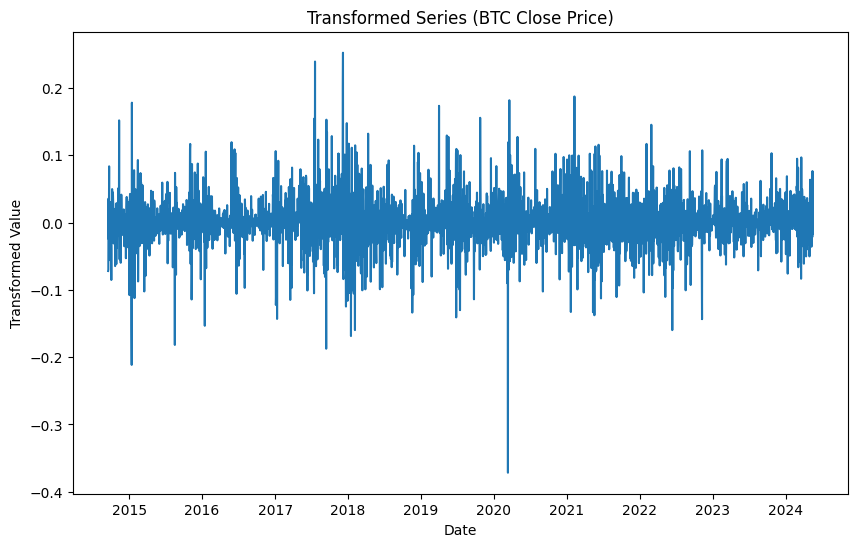

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(btc_dr)
plt.title('Transformed Series (BTC Close Price)')
plt.xlabel('Date')
plt.ylabel('Transformed Value')
plt.show()

Las transformaciones suelen ser útiles para estabilizar una serie antes de estimar modelos. Esto es especialmente importante para modelos estadisticos que necesitan que las series sean estacionarias antes de estimar los modelos. Una serie es estacionaria si el nivel global (media) y la desvianza media del nivel (varianza) son constantes a lo largo de la serie.

Esto tiene una importante implicación a la hora de predecir. Pues de tener estacionariedad, estariamos prediciendo que las características estadísticas de nuestra serie de tiempo serán las mismas en el futuro como en el pasado.

Note que luego de aplicar nuestra transformacion logaritimica podemos observar que la distribucion de nuestra serie no varia a lo largo del tiempo o en términos más concretos, la media y la varianza de una serie estacionaria no cambian con el tiempo y por ende no siguen una tendencia demarcada
   

### • Mediante agregación por grupos, analice el comportamiento de la media y desviación estándar, agrupando por semanas, días, meses. Además, para estas agrupaciones, calcule estadísticos móviles

---



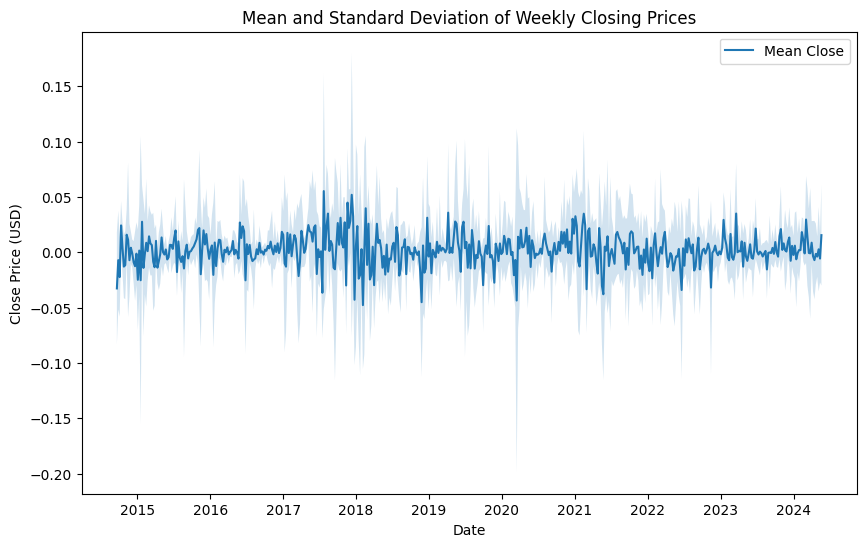

In [ ]:
weekly_btc = btc_dr.resample('W').agg(['mean', 'std'])

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(weekly_btc.index, weekly_btc['mean'], label='Mean Close')
ax.fill_between(weekly_btc.index, weekly_btc['mean'] - weekly_btc['std'],
                weekly_btc['mean'] + weekly_btc['std'], alpha=0.2)

ax.set_title('Mean and Standard Deviation of Weekly Closing Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price (USD)')
ax.legend()

plt.show()

A partir del siguiente agrupamiento por semanas, podemos ver la gran variabilidad del activo y a pesar de que no se observan tendencias marcadas en cuanto a su media. Se observa como el precio aumenta y decrece a lo largo de las semanas, sin embargo han mantenido un incremento en su valor en comparacion a otros activos como las monedas fiat

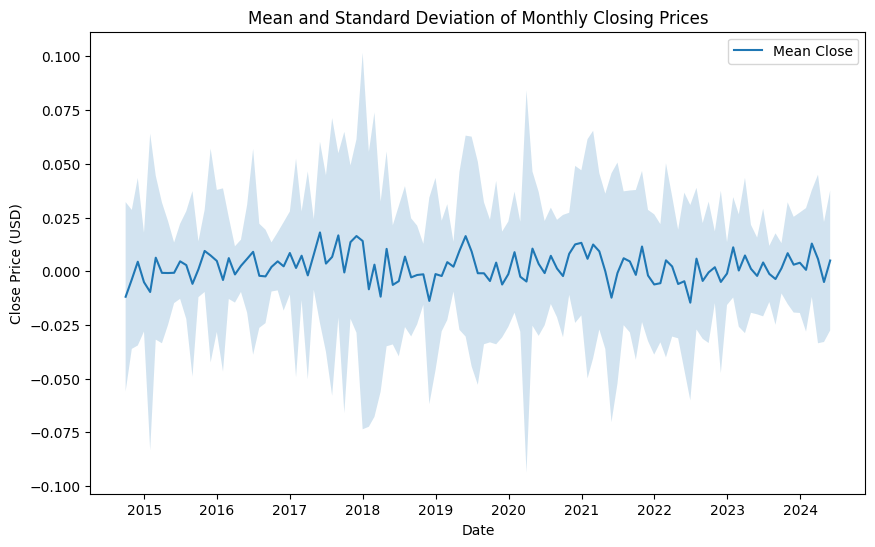

In [ ]:
monthly_btc = btc_dr.resample('M').agg(['mean', 'std'])

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(monthly_btc.index, monthly_btc['mean'], label='Mean Close')
ax.fill_between(monthly_btc.index, monthly_btc['mean'] - monthly_btc['std'],
                monthly_btc['mean'] + monthly_btc['std'], alpha=0.2)

ax.set_title('Mean and Standard Deviation of Monthly Closing Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price (USD)')
ax.legend()

plt.show()

En este caso particular, vemos como la serie esta con menos presencia de ruido. Sin embargo, por la naturaleza de nuestro activo podemos ver como su varianza y precio medio no se mantienen constantes a lo largo de las observaciones y esto representa un problema en la estimación del riesgo.
Ya que estaremos subestimando el riesgo, porque la distribución tiene colas más largas en algunos meses, esto implicaria una sobrestimacion de los beneficios o las perdidas y en consecuencia mayores errores.



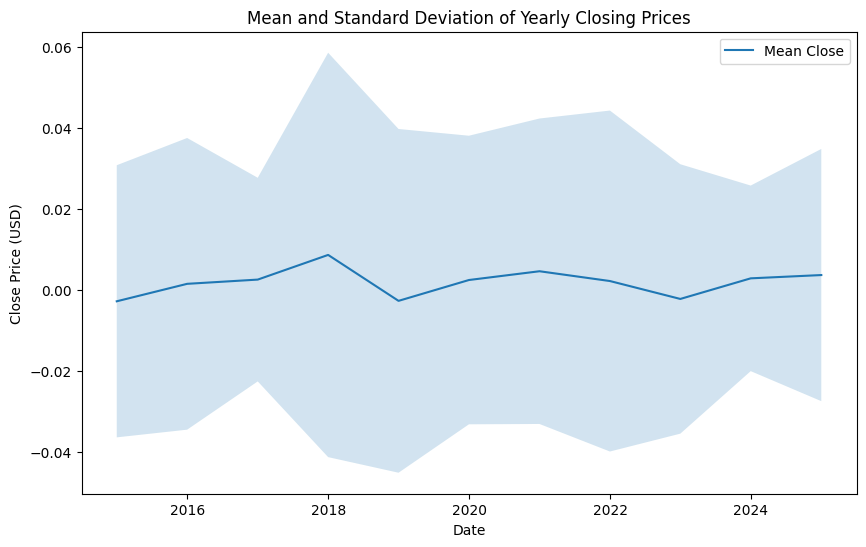

In [ ]:
yearly_btc = btc_dr.resample('Y').agg(['mean', 'std'])

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(yearly_btc.index, yearly_btc['mean'], label='Mean Close')
ax.fill_between(yearly_btc.index, yearly_btc['mean'] - yearly_btc['std'],
                yearly_btc['mean'] + yearly_btc['std'], alpha=0.2)

ax.set_title('Mean and Standard Deviation of Yearly Closing Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price (USD)')
ax.legend()

plt.show()

Esta serie agrupada por anualidades muestra como el precio de cierre se ha mantenido a lo largo de los años sin embargo ha variado el precio del activo de manera irregular. Esto es normalmente comun en el sector de las criptomonedas
ya que son activos con falta de normas que las regulen, lo reciente que son y lo fácil que se pueden alterar o perder por problemas técnicos o ataques informáticos. También influye que el mercado está muy dividido y tiene escasez de liquidez debido a esa fragmentación, lo que hace que los precios cambien mucho.

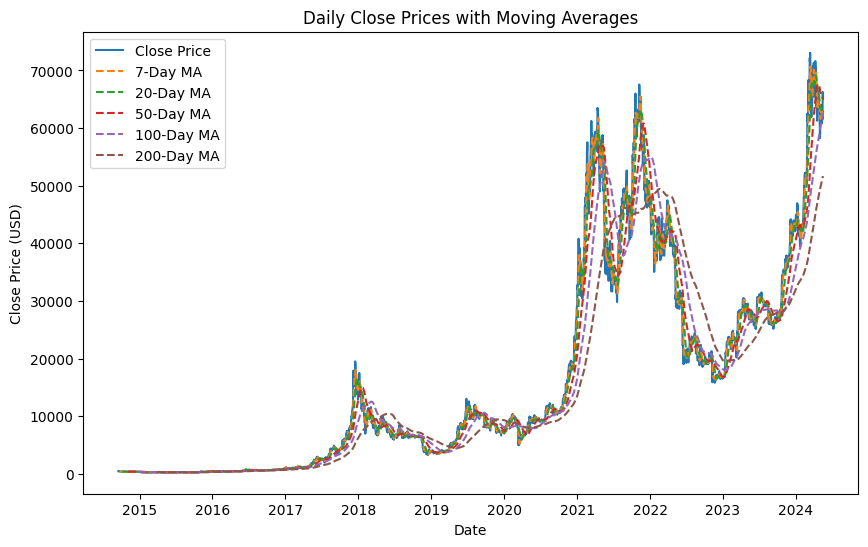

In [ ]:
btc['7_day_MA'] = btc['close'].rolling(window=7).mean()
btc['20_day_MA'] = btc['close'].rolling(window=20).mean()
btc['50_day_MA'] = btc['close'].rolling(window=50).mean()
btc['100_day_MA'] = btc['close'].rolling(window=100).mean()
btc['200_day_MA'] = btc['close'].rolling(window=200).mean()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(btc.index, btc['close'], label='Close Price')
ax.plot(btc.index, btc['7_day_MA'], label='7-Day MA', linestyle='--')
ax.plot(btc.index, btc['20_day_MA'], label='20-Day MA', linestyle='--')
ax.plot(btc.index, btc['50_day_MA'], label='50-Day MA', linestyle='--')
ax.plot(btc.index, btc['100_day_MA'], label='100-Day MA', linestyle='--')
ax.plot(btc.index, btc['200_day_MA'], label='200-Day MA', linestyle='--')

ax.set_title('Daily Close Prices with Moving Averages')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price (USD)')
ax.legend()

plt.show()


A partir del grafico anterior podemos ver como al aumentar las medias moviles, se suaviza mucho mas la serie ya que se elimina el ruido aleatorio. Adicionalmente, note que en las ultimas suavizaciones (100-200) ya se puede presenciar la presencia de tendencias o ciclos del precio de cierre del activo. Lo que hace nuestra serie no estacionaria a simple vista

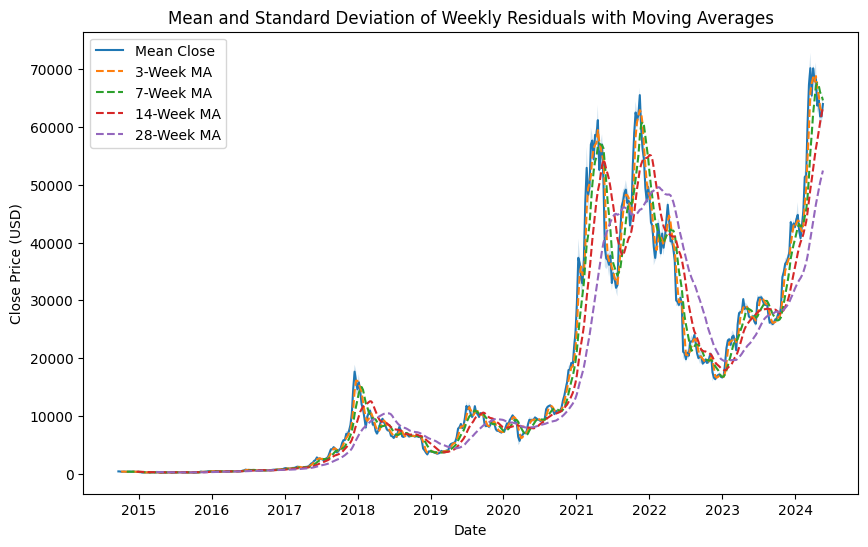

In [ ]:
weekly_btc = btc.groupby(pd.Grouper(freq='W')).agg(
    mean_close=('close', 'mean'),
    std_close=('close', 'std')
)

weekly_btc['3_week_MA'] = weekly_btc['mean_close'].rolling(window=3).mean()
weekly_btc['7_week_MA'] = weekly_btc['mean_close'].rolling(window=7).mean()
weekly_btc['14_week_MA'] = weekly_btc['mean_close'].rolling(window=14).mean()
weekly_btc['28_week_MA'] = weekly_btc['mean_close'].rolling(window=28).mean()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(weekly_btc.index, weekly_btc['mean_close'], label='Mean Close')
ax.fill_between(weekly_btc.index, weekly_btc['mean_close'] - weekly_btc['std_close'],
                weekly_btc['mean_close'] + weekly_btc['std_close'], alpha=0.2)

ax.plot(weekly_btc.index, weekly_btc['3_week_MA'], label='3-Week MA', linestyle='--')
ax.plot(weekly_btc.index, weekly_btc['7_week_MA'], label='7-Week MA', linestyle='--')
ax.plot(weekly_btc.index, weekly_btc['14_week_MA'], label='14-Week MA', linestyle='--')
ax.plot(weekly_btc.index, weekly_btc['28_week_MA'], label='28-Week MA', linestyle='--')

ax.set_title('Mean and Standard Deviation of Weekly Residuals with Moving Averages')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price (USD)')
ax.legend()

plt.show()


Analogamente al grafico anterior, podemos como la media del precio de cierre se suaviza a medida que incrementan las ventanas. Esto apoya nuestras inferencias de como el bitcoin ha incrementado su valor de los años y lo variable que ha sido ese proceso. Esto muestra la importancia de la media movil como un suavizador de datos lineal, sin embargo, la presencia de datos atipicos en los precios de cierre de nuestro activo hace que ciertas medias moviles se encuentren dominadas y por eso se presencian algunos picos en las trazas de nuestras lineas.


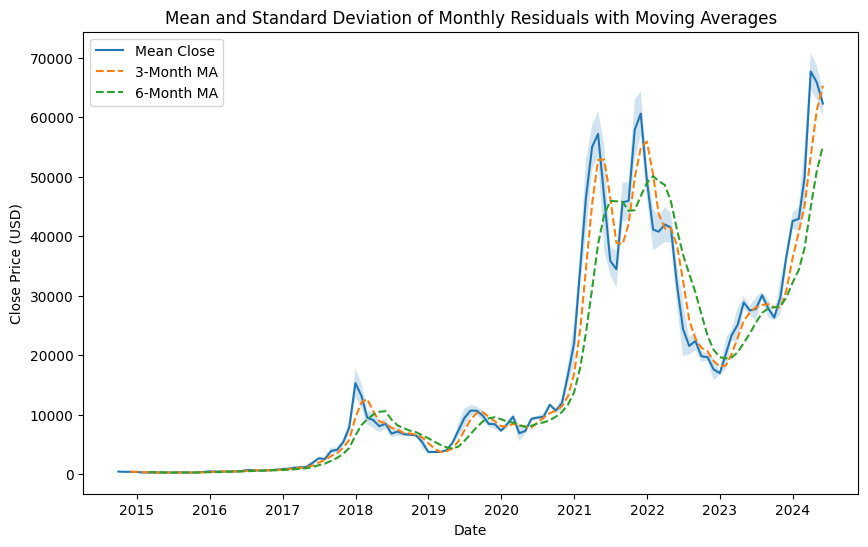

In [ ]:
monthly_btc = btc.groupby(pd.Grouper(freq='M')).agg(
    mean_close=('close', 'mean'),
    std_close=('close', 'std')
)

monthly_btc['3_month_MA'] = monthly_btc['mean_close'].rolling(window=3).mean()
monthly_btc['6_month_MA'] = monthly_btc['mean_close'].rolling(window=6).mean()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(monthly_btc.index, monthly_btc['mean_close'], label='Mean Close')
ax.fill_between(monthly_btc.index, monthly_btc['mean_close'] - monthly_btc['std_close'],
                monthly_btc['mean_close'] + monthly_btc['std_close'], alpha=0.2)

ax.plot(monthly_btc.index, monthly_btc['3_month_MA'], label='3-Month MA', linestyle='--')
ax.plot(monthly_btc.index, monthly_btc['6_month_MA'], label='6-Month MA', linestyle='--')

ax.set_title('Mean and Standard Deviation of Monthly Residuals with Moving Averages')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price (USD)')
ax.legend()

plt.show()


De la anterior grafica, vemos como se suaviza las fluctuaciones de plazos cortos y se resaltan algunas tendencias del activo y posibles ciclos a largo plazo. Aun asi, se puede observar la gran variabilidad en el precio y su aumento a lo largo del tiempo

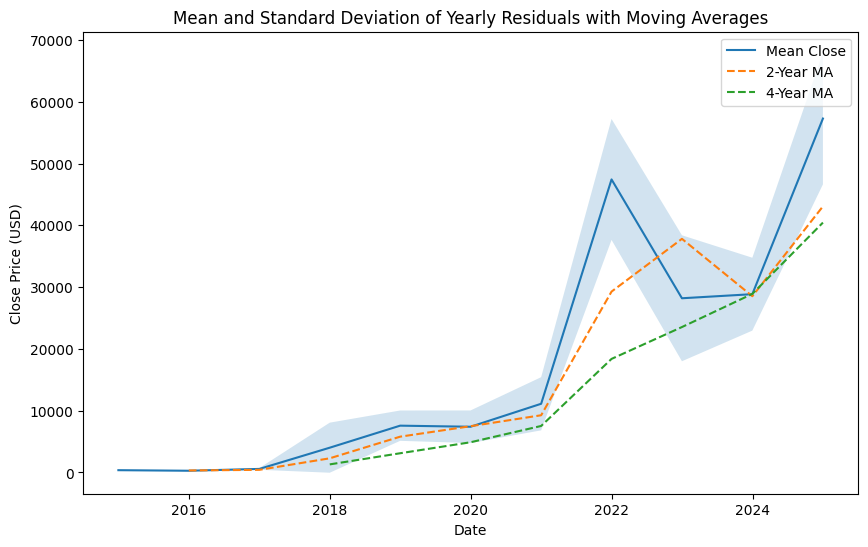

In [ ]:
yearly_btc = btc.groupby(pd.Grouper(freq='Y')).agg(
    mean_close=('close', 'mean'),
    std_close=('close', 'std')
)

yearly_btc['2_year_MA'] = yearly_btc['mean_close'].rolling(window=2).mean()
yearly_btc['4_year_MA'] = yearly_btc['mean_close'].rolling(window=4).mean()

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(yearly_btc.index, yearly_btc['mean_close'], label='Mean Close')
ax.fill_between(yearly_btc.index, yearly_btc['mean_close'] - yearly_btc['std_close'],
                yearly_btc['mean_close'] + yearly_btc['std_close'], alpha=0.2)

ax.plot(yearly_btc.index, yearly_btc['2_year_MA'], label='2-Year MA', linestyle='--')
ax.plot(yearly_btc.index, yearly_btc['4_year_MA'], label='4-Year MA', linestyle='--')

ax.set_title('Mean and Standard Deviation of Yearly Residuals with Moving Averages')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price (USD)')
ax.legend()

plt.show()


Al hacer medias moviles por periodos de 2 y 4 años, observamos la tendencia alcista del bitcoin de una forma muy marcada. Sin embargo, la varianza en el precio se delimita con mayor fuerza a partir del año 2021 y se mantiene hasta el año presente, donde el bitcoin alcanzo un precio historico

### • Aplique las medias móviles ... a la serie del precio de cierre de BTC-USD. Posteriormente, úselas para remover tendencia y aplique la prueba de Dickey Fuller y LJung Box para verificar si se logró estacionariedad

In [ ]:
MA2 = btc.close.rolling(window=2).mean()
TwoXMA2 = MA2.rolling(window=2).mean()

MA4 = btc.close.rolling(window=4).mean()
TwoXMA4 = MA4.rolling(window=2).mean()

MA3 = btc.close.rolling(window=3).mean()
ThreeXMA3 = MA3.rolling(window=3).mean()

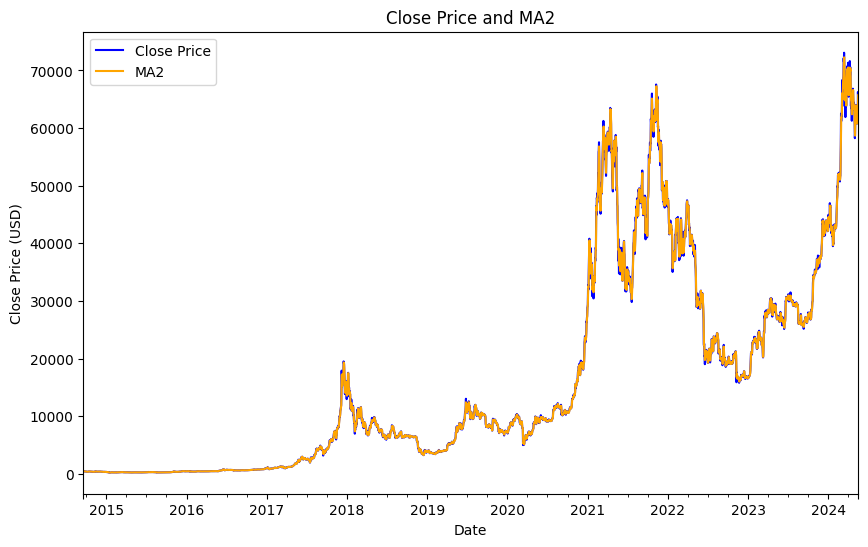

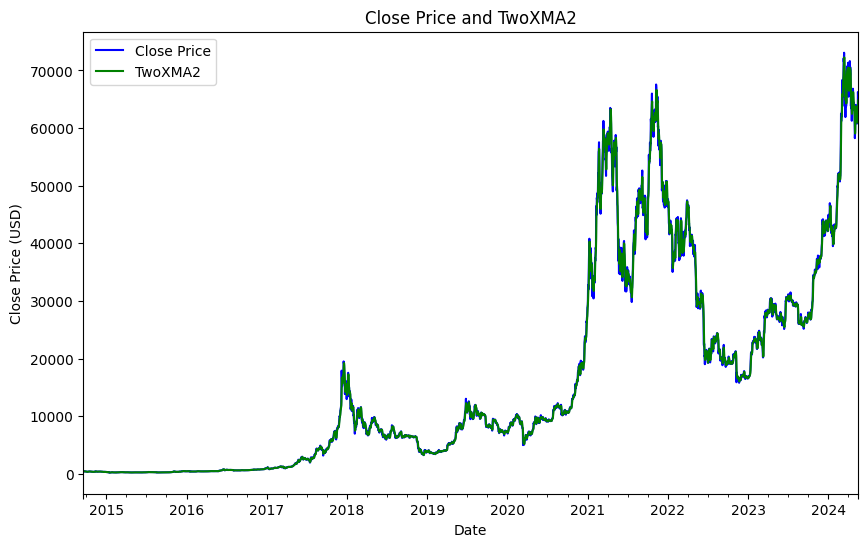

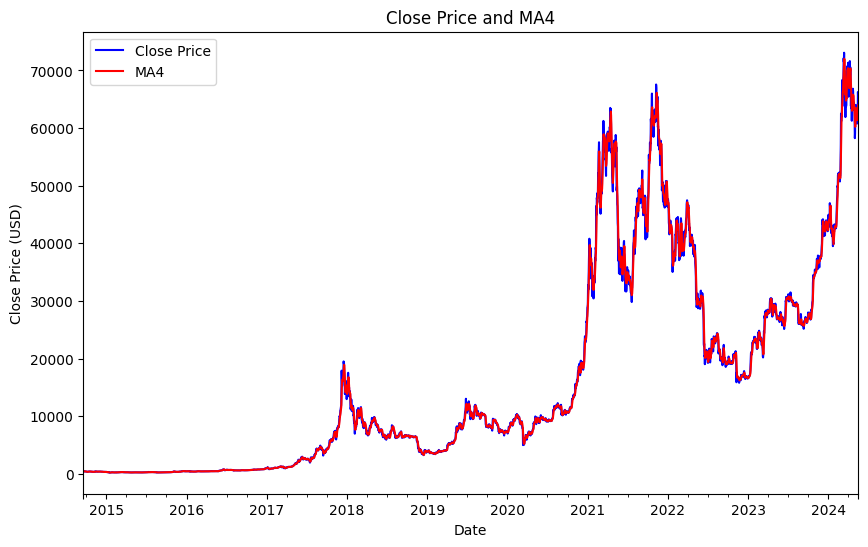

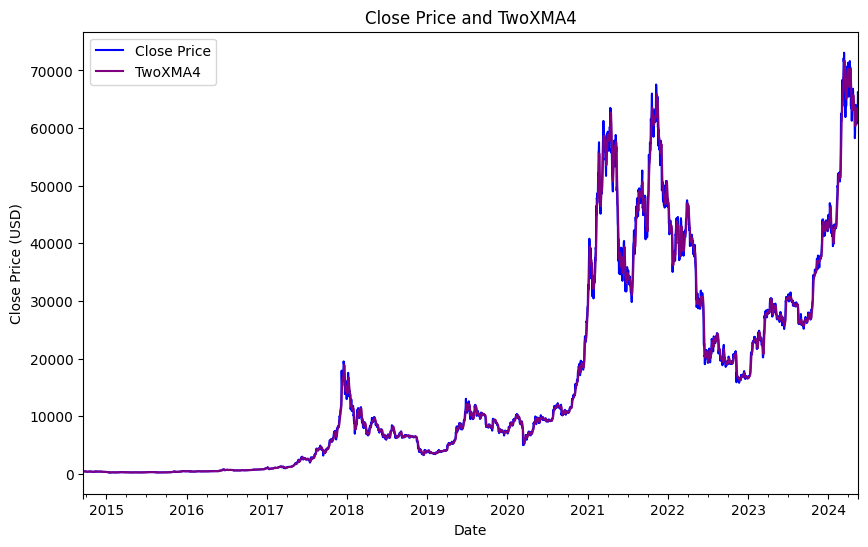

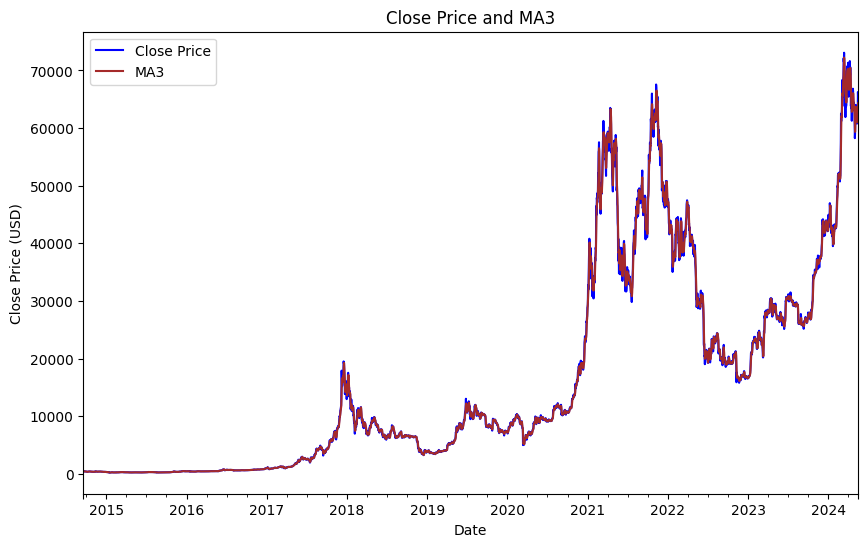

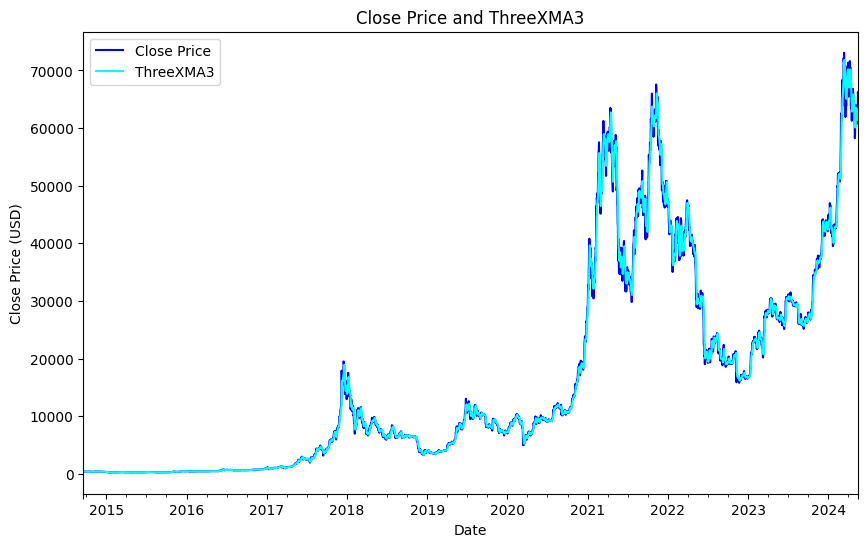

In [ ]:
plt.figure(figsize=(10, 6))
btc['close'].plot(label='Close Price', color='blue')
MA2.plot(label='MA2', color='orange')
plt.title('Close Price and MA2')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
btc['close'].plot(label='Close Price', color='blue')
TwoXMA2.plot(label='TwoXMA2', color='green')
plt.title('Close Price and TwoXMA2')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
btc['close'].plot(label='Close Price', color='blue')
MA4.plot(label='MA4', color='red')
plt.title('Close Price and MA4')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
btc['close'].plot(label='Close Price', color='blue')
TwoXMA4.plot(label='TwoXMA4', color='purple')
plt.title('Close Price and TwoXMA4')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
btc['close'].plot(label='Close Price', color='blue')
MA3.plot(label='MA3', color='brown')
plt.title('Close Price and MA3')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
btc['close'].plot(label='Close Price', color='blue')
ThreeXMA3.plot(label='ThreeXMA3', color='cyan')
plt.title('Close Price and ThreeXMA3')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

Luego de hacer esta suavizacion de medias moviles vemos que no se mejora mucho la suavizacion, una posible justificacion es que estamos ante la presencia de mucho ruido ya que son demasiadas observaciones y ademas tengamos en cuenta que la suavidad de los **MA** resultantes mejora con el aumento del orden **m** y el numero de repeticiones **n**.

In [ ]:
btc['MA2'] = btc['close'].rolling(window=2).mean()
btc['TwoXMA2'] = btc['MA2'].rolling(window=2).mean()

btc['MA4'] = btc['close'].rolling(window=4).mean()
btc['TwoXMA4'] = btc['MA4'].rolling(window=2).mean()

btc['MA3'] = btc['close'].rolling(window=3).mean()
btc['ThreeXMA3'] = btc['MA3'].rolling(window=3).mean()

# Subtracting the moving averages from btc.close
btc['close_minus_MA2'] = btc['close'] - btc['MA2']
btc['close_minus_TwoXMA2'] = btc['close'] - btc['TwoXMA2']

btc['close_minus_MA4'] = btc['close'] - btc['MA4']
btc['close_minus_TwoXMA4'] = btc['close'] - btc['TwoXMA4']

btc['close_minus_MA3'] = btc['close'] - btc['MA3']
btc['close_minus_ThreeXMA3'] = btc['close'] - btc['ThreeXMA3']

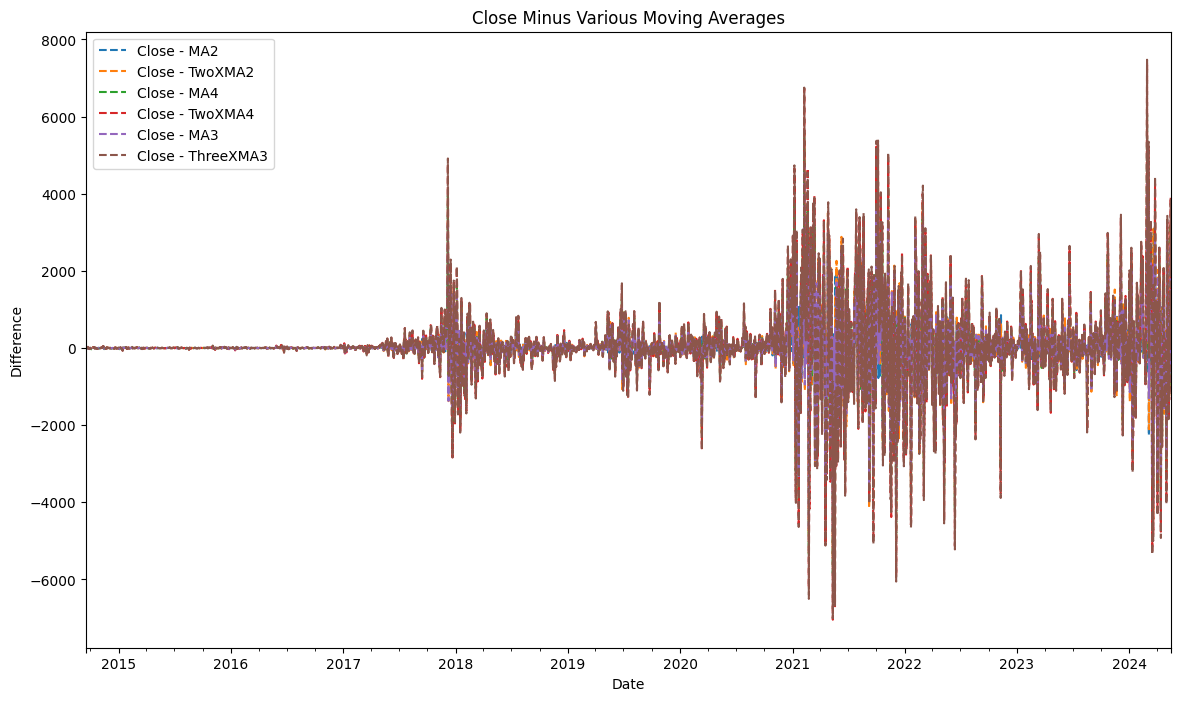

In [ ]:
plt.figure(figsize=(14, 8))
btc['close_minus_MA2'].plot(label='Close - MA2', linestyle='--')
btc['close_minus_TwoXMA2'].plot(label='Close - TwoXMA2', linestyle='--')
btc['close_minus_MA4'].plot(label='Close - MA4', linestyle='--')
btc['close_minus_TwoXMA4'].plot(label='Close - TwoXMA4', linestyle='--')
btc['close_minus_MA3'].plot(label='Close - MA3', linestyle='--')
btc['close_minus_ThreeXMA3'].plot(label='Close - ThreeXMA3', linestyle='--')

plt.title('Close Minus Various Moving Averages')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.legend()
plt.show()

Notemos en esta grafica que luego de incrementar los ordenes, por medio de la suavizacion pudimos obtener una serie con propiedades de estacionaridad. Es decir, de varianza y media constante a lo largo de las observaciones. En ese orden de ideas, una serie estacionaria es mucho más fácil de predecir ya que podremos suponer que se seguirá comportando de la misma forma en el futuro

In [ ]:
close_minus_cols = list(filter(lambda c: "close_minus" in c, btc.columns))

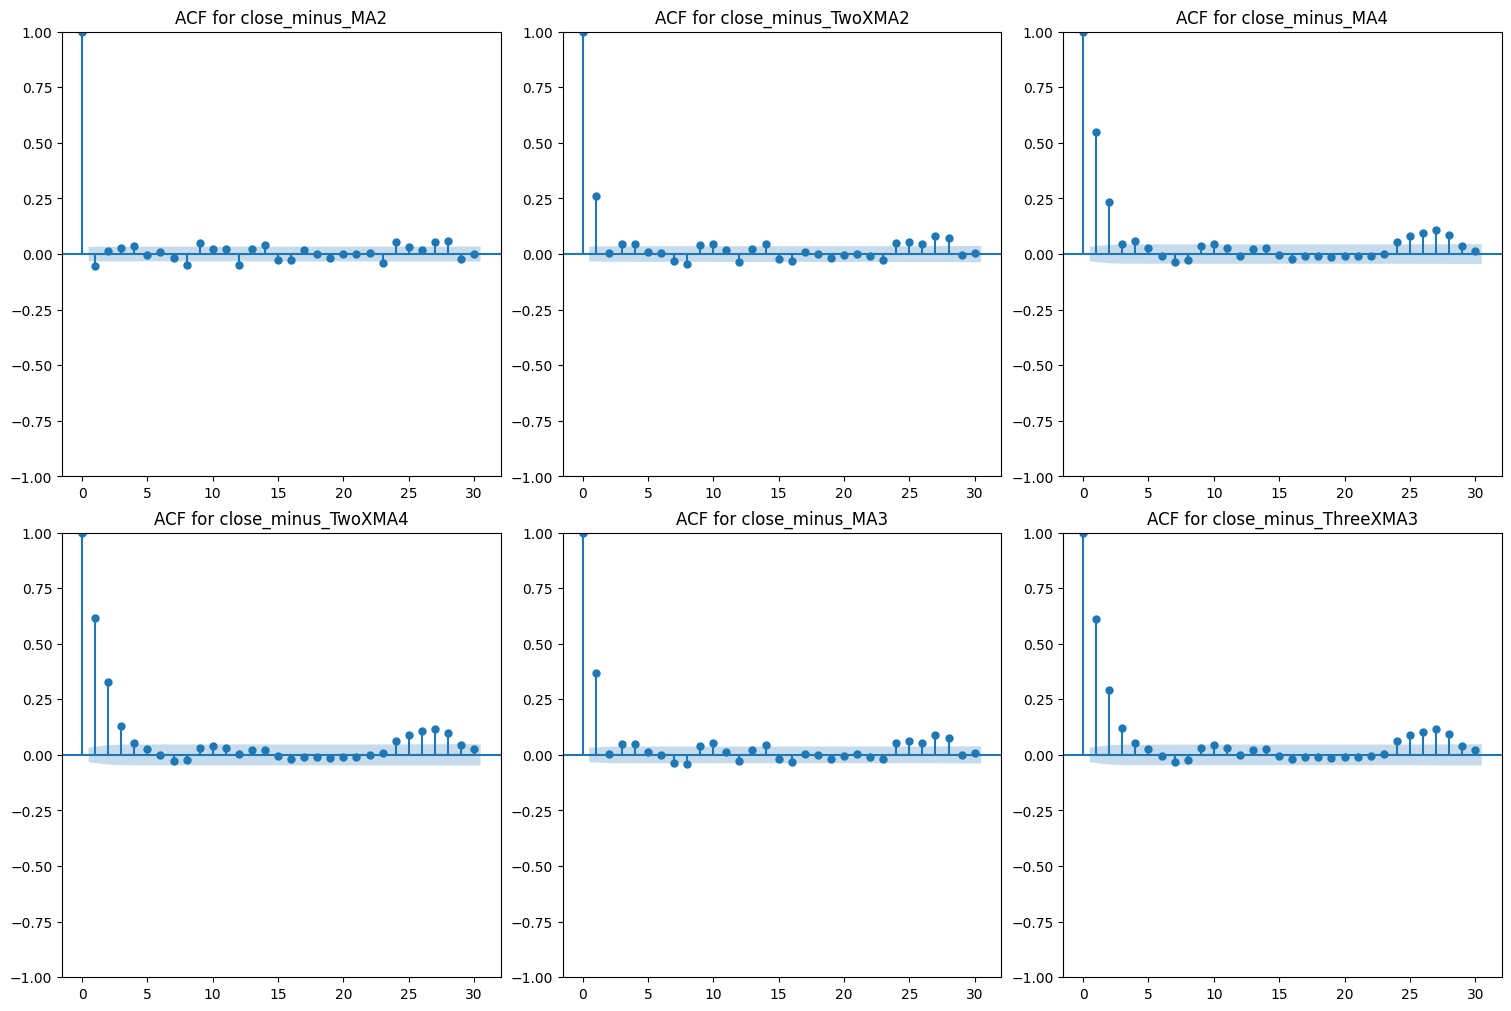

In [ ]:
num_columns = 3

num_rows = (len(close_minus_cols) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5), constrained_layout=True)

axes = axes.flatten()

for i, co in enumerate(close_minus_cols):
    plot_acf(btc[co].dropna(), lags=30, ax=axes[i])
    axes[i].set_title(f'ACF for {co}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

De la anterior grafica, notamos como en algunas medias moviles determinadas, obtenemos pocas observaciones significativas en el diagrama ACF, ya que a lo largo del resto de lags las observaciones restantes caen sobre la region de no significancia. Sin embargo, realizar este tipo de hipotesis a partir de las graficas no puede resultar productivo.
Por lo que realizaremos las pruebas de hipotesis correspondientes

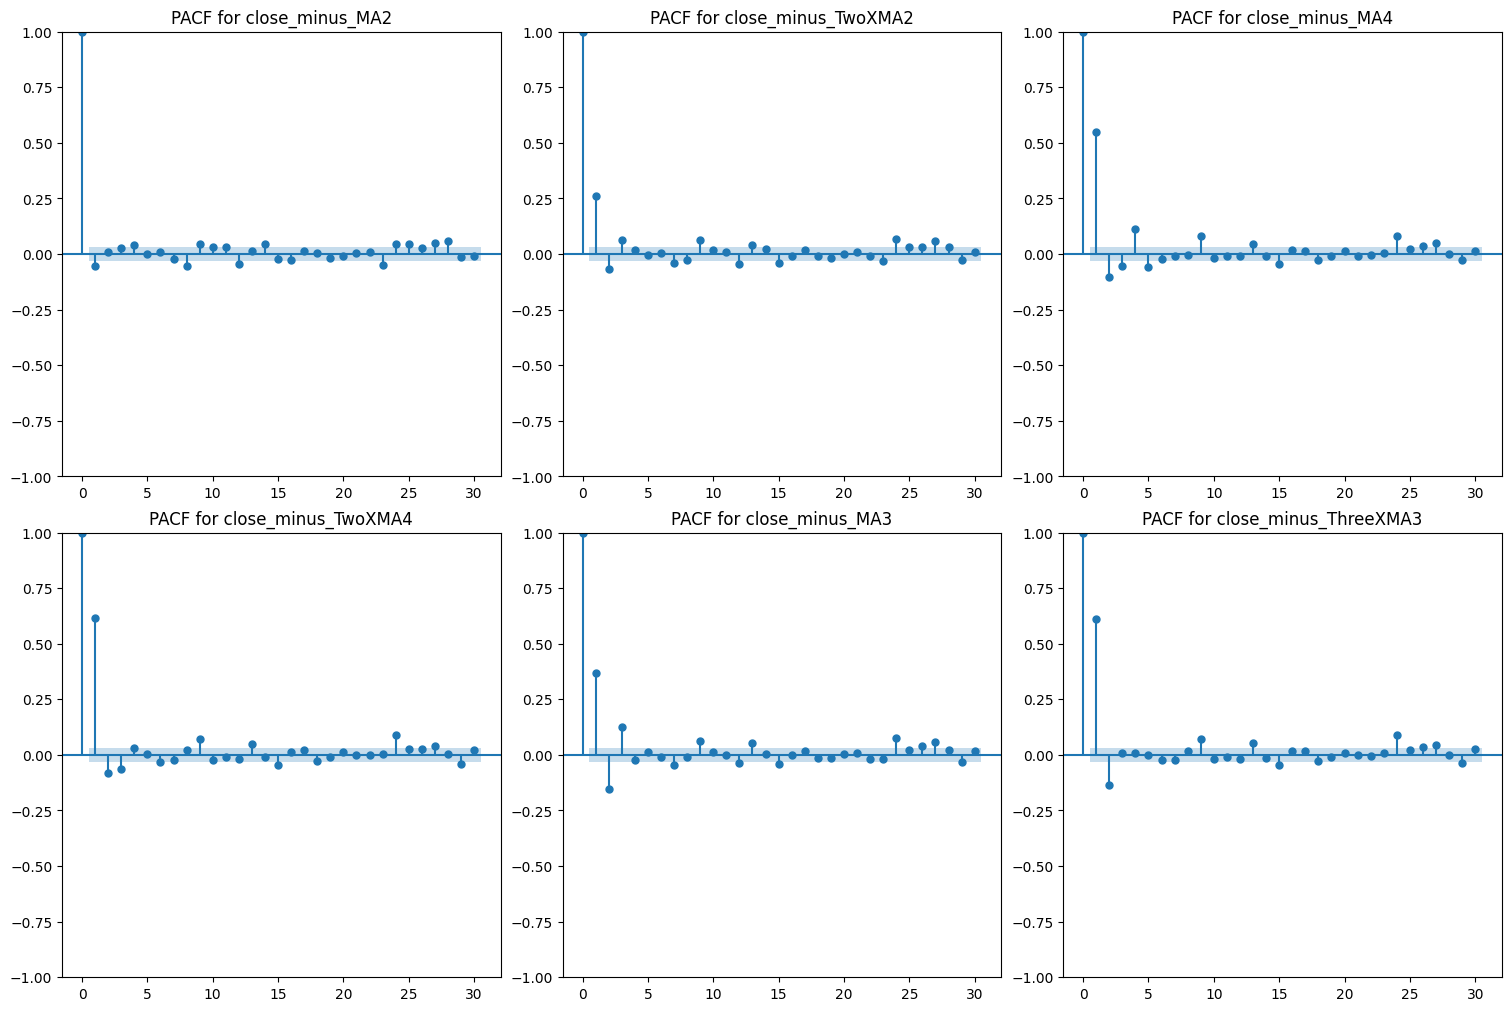

In [ ]:
num_columns = 3

num_rows = (len(close_minus_cols) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 5), constrained_layout=True)

axes = axes.flatten()

for i, co in enumerate(close_minus_cols):
    plot_pacf(btc[co].dropna(), lags=30, ax=axes[i])
    axes[i].set_title(f'PACF for {co}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.show()

In [ ]:
alpha = 0.05
nlags = 30
for co in close_minus_cols:
    acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(btc[co].dropna(), nlags=nlags, qstat=True, alpha=0.05)
    lags = set(range(1, nlags))
    rejected = set(l for l, p_val in enumerate(pvalues_djia) if p_val <= alpha)
    print(f'Null hypothesis is rejected at lags = {rejected} for {co}')
    print(f'Null hypothesis is accepted at lags = {lags - rejected} for {co}')


Null hypothesis is rejected at lags = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29} for close_minus_MA2
Null hypothesis is accepted at lags = set() for close_minus_MA2
Null hypothesis is rejected at lags = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29} for close_minus_TwoXMA2
Null hypothesis is accepted at lags = set() for close_minus_TwoXMA2
Null hypothesis is rejected at lags = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29} for close_minus_MA4
Null hypothesis is accepted at lags = set() for close_minus_MA4
Null hypothesis is rejected at lags = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29} for close_minus_TwoXMA4
Null hypothesis is accepted at lags = set() for close_minus_TwoXMA4
Null hypothesis is rejected at lags = {0, 1, 2, 3, 4

Luego de realizar las pruebas de hipotesis para cada media movil a lo largo de los lags podemos inferir que las medias moviles han logrado estacionar la serie.

In [ ]:
len(pvalues_djia)

30

In [ ]:
for co in close_minus_cols:
    adf_result = stattools.adfuller(btc[co].dropna(), autolag='AIC')
    print(f'p-val of the ADF test in {co}: {adf_result[1]}')

p-val of the ADF test in close_minus_MA2: 1.7997565680789554e-15
p-val of the ADF test in close_minus_TwoXMA2: 1.2048967047208613e-15
p-val of the ADF test in close_minus_MA4: 2.399026375905973e-15
p-val of the ADF test in close_minus_TwoXMA4: 1.419803022069833e-15
p-val of the ADF test in close_minus_MA3: 1.0932034435019656e-15
p-val of the ADF test in close_minus_ThreeXMA3: 1.3752441231221838e-15


Con la prueba de Dickey Fuller aumentada vemos que en cada una de las medias moviles. El p valor es menor a 0.05 y por lo tanto cae en la region de rechazo, en ese orden de ideas, aceptamos la hipotesis nula que establece no existe raiz unitaria y la serie es estacionaria

###  Realice descomposición de la serie temporal del precio de cierre de BTC-USD usando medias moviles y además usando la librería statsmodels.tsa. Verifique al final independencia de los residuos mediante la prueba de LJung Box.

In [ ]:
MA200 = btc.close.rolling(window=50).mean()
trendComp = MA200.rolling(window=2).mean()
residuals = btc.close - trendComp
seasonalComp = residuals.rolling(window=30).mean()
irrComp = btc.close - trendComp - seasonalComp

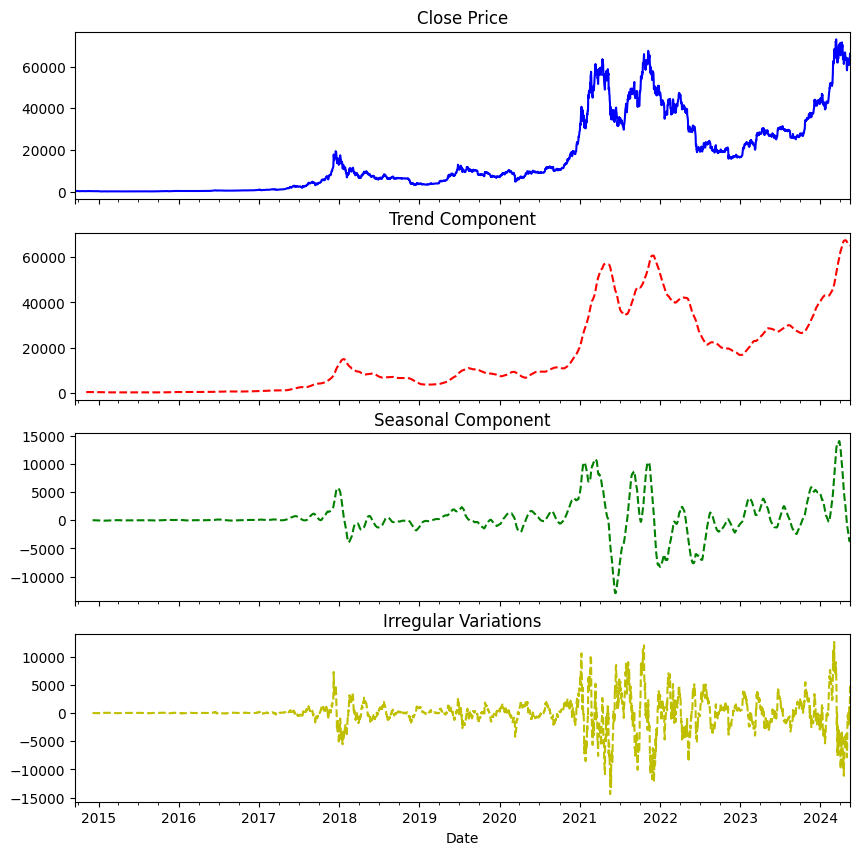

In [ ]:
fig, axarr = plt.subplots(4, sharex = True)
fig.set_size_inches(10, 10)

btc.close.plot(ax = axarr[0], color='b', linestyle='-')
axarr[0].set_title('Close Price')

trendComp.plot(ax = axarr[1], color='r', linestyle='--')
axarr[1].set_title('Trend Component')

seasonalComp.plot(ax = axarr[2], color='g', linestyle='--')
axarr[2].set_title('Seasonal Component')

irrComp.plot(ax = axarr[3], color='y', linestyle='--')
axarr[3].set_title('Irregular Variations')

plt.show()


In [ ]:
alpha = 0.05
nlags = 30
acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(irrComp.dropna(), nlags=nlags, qstat=True, alpha=alpha)
print(pvalues_djia)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


Lo anterior prueba de hipotesis sugiere la independencia de los residuos a lo largo de los lags. Es importante que los residuos no tengan un patrón identificable entre ellos y de esta forma promover modelos sin implementacion sesgada

In [ ]:
adf = stattools.adfuller(irrComp.dropna(), autolag='AIC')
print(f'ADF Statistic: {adf[0]}')
print(f'p-value: {adf[1]}')
print(f'Number of Lags Used: {adf[2]}')
print(f'Number of Observations Used: {adf[3]}')

ADF Statistic: -10.553648766648104
p-value: 8.055658021893377e-19
Number of Lags Used: 29
Number of Observations Used: 3421


In [ ]:
from statsmodels.tsa import seasonal

In [ ]:
descompose_model = seasonal.seasonal_decompose(btc.close, period=365, model='additive')

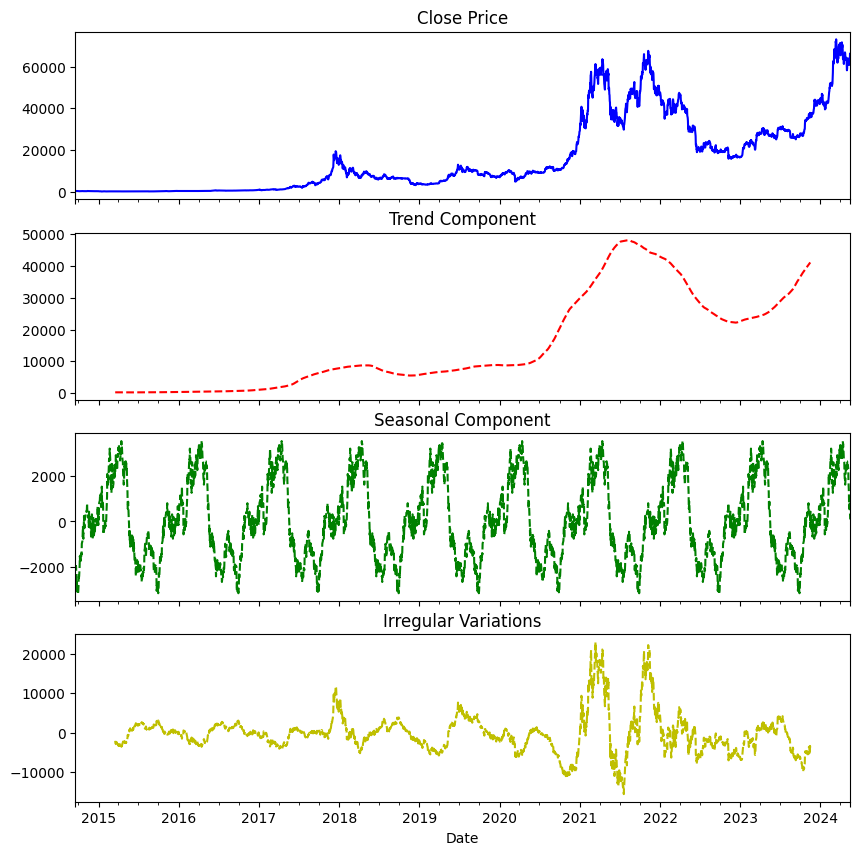

In [ ]:
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(10, 10)

btc.close.plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('Close Price')

descompose_model.trend.plot(ax=axarr[1], color='r', linestyle='--')
axarr[1].set_title('Trend Component')

descompose_model.seasonal.plot(ax=axarr[2], color='g', linestyle='--')
axarr[2].set_title('Seasonal Component')

descompose_model.resid.plot(ax=axarr[3], color='y', linestyle='--')
axarr[3].set_title('Irregular Variations')

plt.show()


De la anterior grafica podemos ver la decomposicion aditiva de la serie. En primer lugar vemos que hay una componente de tendencia altamente marcada, que muestra el incremento del activo. Por otra parte la estacionalidad y los residuos lucen con bastante aleatoridad, lo cual es bueno al momento de ajustar las predicciones que deseemos realizar.

Sin embargo, para futuras experiencias se podrian explorar otros metodos de descomposicion que nos permiten indagar en mas caracteristicas de la serie

In [ ]:
alpha = 0.05
nlags = 30
acf_djia, confint_djia, qstat_djia, pvalues_djia = stattools.acf(descompose_model.resid.dropna(), nlags=nlags, qstat=True, alpha=alpha)
print(pvalues_djia)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


Lo anterior prueba de hipotesis sugiere la independencia de los residuos a lo largo de los lags. Es importante que los residuos no tengan un patrón identificable entre ellos y de esta forma promover modelos sin implementacion sesgada

# Ejercicio 2

## Modelos Estadísticos

En cada uno de los siguientes ejercicios considere los siguientes pasos para construir sus modelos
predictivos: (1) Primero, divida el conjunto de datos en entrenamiento, validación y prueba (ver
Figura 1). (2) Para cada conjunto de parámetros, ajuste cada modelo predictivo en el conjunto
de entrenamiento, y dentro de sus iteraciones de búsqueda, evalúe su modelo en el conjunto
de validación usando las siguientes métricas: MAPE, RMSE y el R cuadrado ajustado R2
adj. (3)
Realice una tabla donde resuma los scores obtenidos por cada modelo en el conjunto de prueba
(error de predicción) y agregue además las respectivas pruebas de hipótesis para independencia
y normalidad. Para esto, usando Pandas construya una tabla con las siguientes columnas: MAPE,
RMSE, R2
adj, Kurtosis (p-value), Skewness (p-value), Jarque–Bera (p-value), Dickey Fuller (p-value)
y KPSS test (p-value). (4) Dibuje la serie de tiempo de residuos, su histograma, QQPlot y ACF,
para confirmar independencia y normalidad. Para las predicciones del conjunto de prueba, además,
dibujar intervalo de confianza. (5) Considere conjuntos de validación y prueba de longitud, τ =
7val,test, 14val,test, 21val,test, 28val,test días, el conjunto de entrenamiento corresponde a las primeras
Nyt − (28val + 28test) observaciones (ver Figura 1). Los modelos que debe considerar para este
ejercicio son los siguientes:

### • Simple Exponential Smoothing (Sin Librería)

In [ ]:
btc.close

Date
2014-09-17      457.334015
2014-09-18      424.440002
2014-09-19      394.795990
2014-09-20      408.903992
2014-09-21      398.821014
                  ...     
2024-05-12    61448.394531
2024-05-13    62901.449219
2024-05-14    61552.789062
2024-05-15    66267.492188
2024-05-16    65143.832031
Name: close, Length: 3530, dtype: float64

In [ ]:
def split_data(series, validation_days, test_days):
    """
    Split a time series into training, validation, and test sets.

    Parameters:
    series (pd.Series): The time series data.
    validation_days (int): Number of days for the validation set.
    test_days (int): Number of days for the test set.

    Returns:
    tuple: A tuple containing the training, validation, and test sets.
    """
    total_days = len(series)

    test_start_idx = total_days - test_days
    validation_start_idx = test_start_idx - validation_days

    train_data = series[:validation_start_idx]
    validation_data = series[validation_start_idx:test_start_idx]
    test_data = series[test_start_idx:]

    return train_data, validation_data, test_data

In [ ]:
validation_days = 28
test_days = 28
train_data, validation_data, test_data = split_data(btc.close, validation_days, test_days)
len(train_data), len(validation_data), len(test_data)

(3474, 28, 28)

In [ ]:
def firstsmooth(y, lambda_, start=None):
    ytilde = y.copy()
    if start is None:
        start = y[0]
    ytilde[0] = lambda_ * y[0] + (1 - lambda_) * start
    for i in range(1, len(y)):
        ytilde[i] = lambda_ * y[i] + (1 - lambda_) * ytilde[i - 1]
    return ytilde

In [ ]:
btc_smooth1 = firstsmooth(btc.close, 0.1)

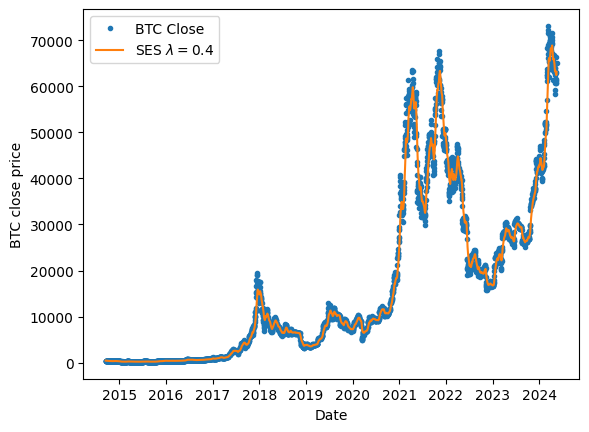

In [ ]:
plt.plot(btc.close, marker='o', linestyle='', markersize=3, label='BTC Close')
plt.plot(btc_smooth1, label='SES $\lambda=0.4$')
plt.xlabel('Date')
plt.ylabel('BTC close price')
plt.legend()
plt.show()

In [ ]:
btc.close.shape

(3530,)

In [ ]:
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
import itertools
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt

### Simple Exponential Smoothing (Usando statsmodels.tsa.holtwinters)

In [ ]:
len(validation_data)

28

In [ ]:
def evaluate_model_residues(y_hat, y):

    y_hat = y_hat.to_numpy().reshape(-1)
    y = y.to_numpy().reshape(-1)

    residues = y - y_hat

    # Calculate statistics
    mape = mean_absolute_percentage_error(y, y_hat)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    r2 = r2_score(y, y_hat)

    kurt_stat, kurt_p_value = kurtosistest(residues)
    skew_stat, skew_p_value = skewtest(residues)
    jb_stat, jb_p_value = jarque_bera(residues)
    adf_stat, adf_p_value, _, _, _, _ = adfuller(residues)
    kpss_stat, kpss_p_value, _, _ = kpss(residues)

    results = {
        'MAPE': mape,
        'RMSE': rmse,
        # 'R2 adj': r2_adj,
        'R2': r2,
        'Kurtosis (statistic)': kurt_stat,
        'Kurtosis (p-value)': kurt_p_value,
        'Skewness (statistic)': skew_stat,
        'Skewness (p-value)': skew_p_value,
        'Jarque-Bera (statistic)': jb_stat,
        'Jarque-Bera (p-value)': jb_p_value,
        'Dickey Fuller (statistic)': adf_stat,
        'Dickey Fuller (p-value)': adf_p_value,
        'KPSS test (statistic)': kpss_stat,
        'KPSS test (p-value)': kpss_p_value
    }

    results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

    # Plotting the time series of residues
    plt.figure(figsize=(10, 6))
    plt.plot(residues)
    plt.title('Time Series of Residues')
    plt.xlabel('Time')
    plt.ylabel('Residues')
    plt.show()

    # Plotting the histogram of residues
    plt.figure(figsize=(10, 6))
    sns.histplot(residues, kde=True)
    plt.title('Histogram of Residues')
    plt.xlabel('Residues')
    plt.ylabel('Frequency')
    plt.show()

    # Q-Q plot of residues
    plt.figure(figsize=(10, 6))
    sm.qqplot(residues, line='s')
    plt.title('Q-Q Plot of Residues')
    plt.show()

    # ACF plot of residues
    plt.figure(figsize=(10, 6))
    sm.graphics.tsa.plot_acf(residues, lags=26)
    plt.title('Autocorrelation Function (ACF) of Residues')
    plt.show()

    return residues, results_df

In [ ]:
def firstsmooth(y, lambda_, start=None):
    ytilde = y.copy()
    if start is None:
        start = y[0]
    ytilde[0] = lambda_ * y[0] + (1 - lambda_) * start
    for i in range(1, len(y)):
        ytilde[i] = lambda_ * y[i] + (1 - lambda_) * ytilde[i - 1]
    return ytilde

def measacc_fs(y_hat, y):
    assert len(y_hat) == len(y)
    T = len(y)
    prederr = y - y_hat
    SSE = sum(prederr**2)
    MAPE = 100 * sum(abs(prederr / y)) / T
    MAD = sum(abs(prederr)) / T
    MSD = sum(prederr**2) / T
    RMSE = np.sqrt(MSD)
    R2 = 1 - (SSE / sum((y - np.mean(y))**2))
    p = 2 # Ask Professor!
    R2_adjusted = 1 - (1 - R2) * (T - 1) / (T - p - 1)
    ret1 = pd.DataFrame({
        "SSE": [SSE],
        "MAPE": [MAPE],
        "MAD": [MAD],
        "MSD": [MSD],
        "RMSE": [RMSE],
        "R2": [R2],
        "R2_adjusted": [R2_adjusted]
    })
    ret1.reset_index(drop=True, inplace=True)
    return ret1

def plot_model(train, validation, test, y_pred, title):

    mae = mean_absolute_error(test, y_pred)
    train[-100:].plot(legend=True, label="Train", title=f"{title}, MAE: {round(mae, 2)}")
    validation.plot(legend=True, label="Validation")
    test.plot(legend=True, label="Test")
    y_pred.plot(legend=True, label="Prediction")
    plt.show()

def ses_optimizer(train, validation, alphas):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        y_pred = firstsmooth(pd.concat([train, validation]), alpha, start=None)
        mae = mean_absolute_error(validation, y_pred[-len(validation):])

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

    return best_alpha, best_mae

def ses_model_tuning(train , validation, test, title="Model Tuning - Single Exponential Smoothing"):

    alphas = np.arange(0.8, 1, 0.01)
    best_alpha, best_mae = ses_optimizer(train, validation, alphas)

    y_pred = firstsmooth(pd.concat([train, validation]), best_alpha, start=None)

    y_pred_test = test.copy()
    y_pred_test[:] = y_pred[-1]

    mae = mean_absolute_error(test, y_pred_test)

    return best_alpha, best_mae, y_pred_test


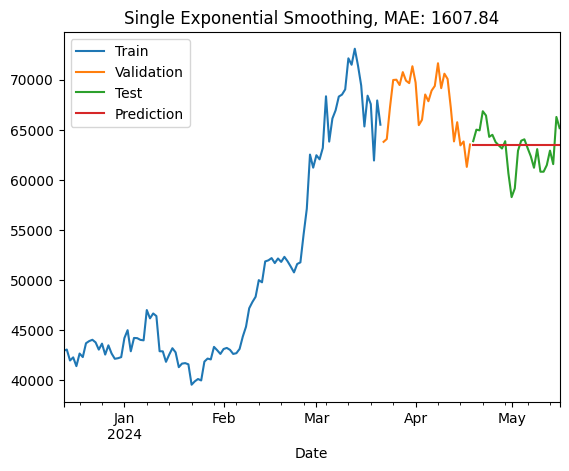

SSE      MAPE          MAD           MSD         RMSE        R2  \
0  1.217607e+08  2.581059  1607.842212  4.348597e+06  2085.329097 -0.032629   

   R2_adjusted  
0     -0.11524

In [ ]:
best_alpha, best_mae, y_pred = ses_model_tuning(train_data, validation_data, test_data)
ret1= measacc_fs(y_pred, test_data)
plot_model(train_data, validation_data, test_data, y_pred, title = "Single Exponential Smoothing")
ret1

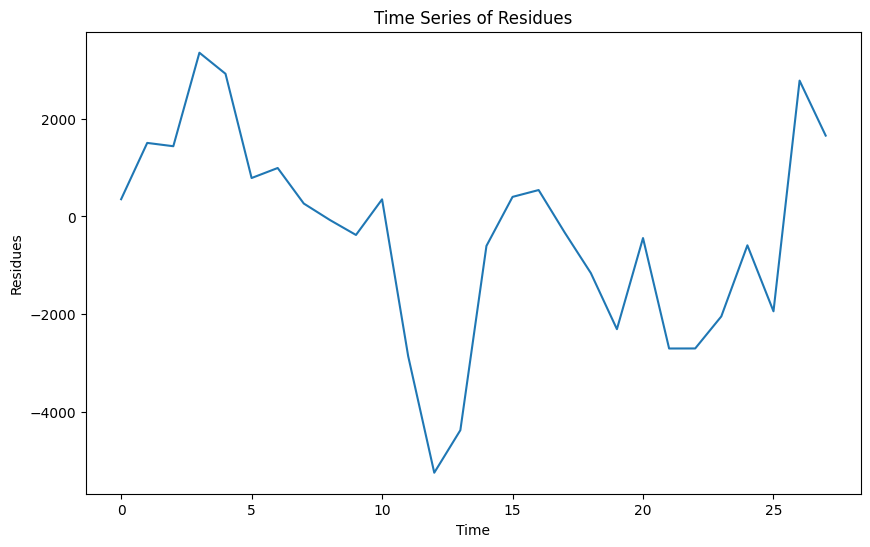

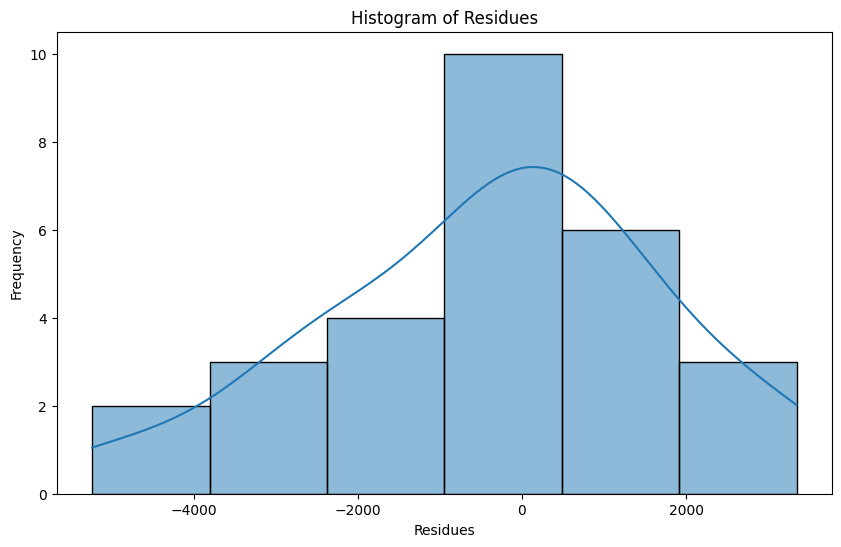

<Figure size 1000x600 with 0 Axes>

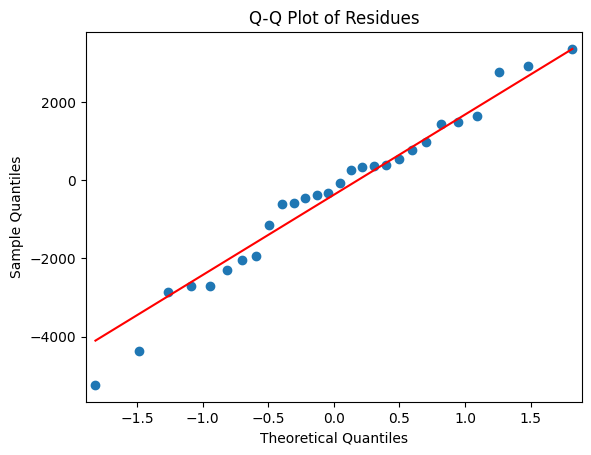

<Figure size 1000x600 with 0 Axes>

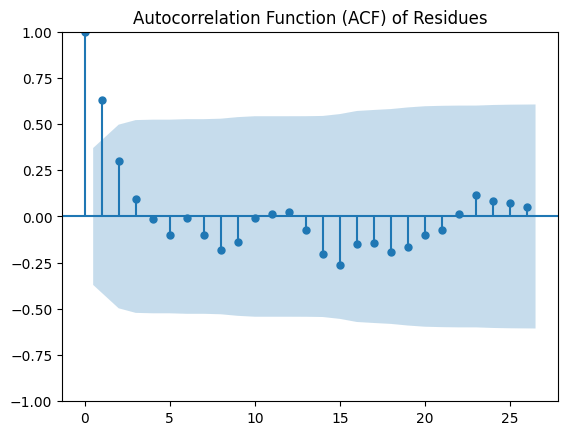

(array([  352.92387678,  1503.79497053,  1435.99809553,  3347.03325178,
         2916.62700178,   786.25200178,   991.06059553,   264.67387678,
          -71.50581072,  -377.41596697,   350.47465803, -2853.79096697,
        -5236.63471697, -4367.21284197,  -600.81049822,   400.82622053,
          540.48637678,  -328.69721697, -1155.83002947, -2302.70502947,
         -440.68549822, -2697.86909197, -2696.93549822, -2042.25190447,
         -589.19721697, -1937.85737322,  2776.84575178,  1653.18559553]),
                                  Value
 MAPE                          0.025811
 RMSE                       2085.329097
 R2                           -0.032629
 Kurtosis (statistic)          0.252491
 Kurtosis (p-value)            0.800662
 Skewness (statistic)         -0.938224
 Skewness (p-value)            0.348129
 Jarque-Bera (statistic)       0.698163
 Jarque-Bera (p-value)         0.705336
 Dickey Fuller (statistic)    -2.825570
 Dickey Fuller (p-value)       0.054713
 KPSS test (st

In [ ]:
evaluate_model_residues(y_pred, test_data)

In [ ]:
def measacc_fs(y_hat, y):
    assert len(y_hat) == len(y)
    T = len(y)
    prederr = y - y_hat
    SSE = sum(prederr**2)
    MAPE = 100 * sum(abs(prederr / y)) / T
    MAD = sum(abs(prederr)) / T
    MSD = sum(prederr**2) / T
    RMSE = np.sqrt(MSD)
    R2 = 1 - (SSE / sum((y - np.mean(y))**2))
    p = 2 # Ask Professor!
    R2_adjusted = 1 - (1 - R2) * (T - 1) / (T - p - 1)
    ret1 = pd.DataFrame({
        "SSE": [SSE],
        "MAPE": [MAPE],
        "MAD": [MAD],
        "MSD": [MSD],
        "RMSE": [RMSE],
        "R2": [R2],
        "R2_adjusted": [R2_adjusted]
    })
    ret1.reset_index(drop=True, inplace=True)
    return ret1

def plot_model(train, validation, test, y_pred, title):

    mae = mean_absolute_error(test, y_pred)
    train[-100:].plot(legend=True, label="Train", title=f"{title}, MAE: {round(mae, 2)}")
    validation.plot(legend=True, label="Validation")
    test.plot(legend=True, label="Test")
    y_pred.plot(legend=True, label="Prediction")
    plt.show()

def ses_optimizer(train, validation, alphas):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha, optimized=False)
        y_pred = ses_model.forecast(len(validation))
        mae = mean_absolute_error(validation, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

    return best_alpha, best_mae

def ses_model_tuning(train , validation, test, title="Model Tuning - Single Exponential Smoothing"):

    alphas = np.arange(0.8, 1, 0.01)
    best_alpha, best_mae = ses_optimizer(train, validation, alphas)

    final_model = SimpleExpSmoothing(pd.concat([train, validation])).fit(smoothing_level=best_alpha, optimized=False)

    y_pred = final_model.forecast(len(test))

    mae = mean_absolute_error(test, y_pred)

    print(best_alpha, best_mae, y_pred)

    # plot_model(train, validation, test, y_pred, title)

    return best_alpha, best_mae, y_pred

0.8 3016.5919022605117 2024-04-19    63167.20301
2024-04-20    63167.20301
2024-04-21    63167.20301
2024-04-22    63167.20301
2024-04-23    63167.20301
2024-04-24    63167.20301
2024-04-25    63167.20301
2024-04-26    63167.20301
2024-04-27    63167.20301
2024-04-28    63167.20301
2024-04-29    63167.20301
2024-04-30    63167.20301
2024-05-01    63167.20301
2024-05-02    63167.20301
2024-05-03    63167.20301
2024-05-04    63167.20301
2024-05-05    63167.20301
2024-05-06    63167.20301
2024-05-07    63167.20301
2024-05-08    63167.20301
2024-05-09    63167.20301
2024-05-10    63167.20301
2024-05-11    63167.20301
2024-05-12    63167.20301
2024-05-13    63167.20301
2024-05-14    63167.20301
2024-05-15    63167.20301
2024-05-16    63167.20301
Freq: D, dtype: float64


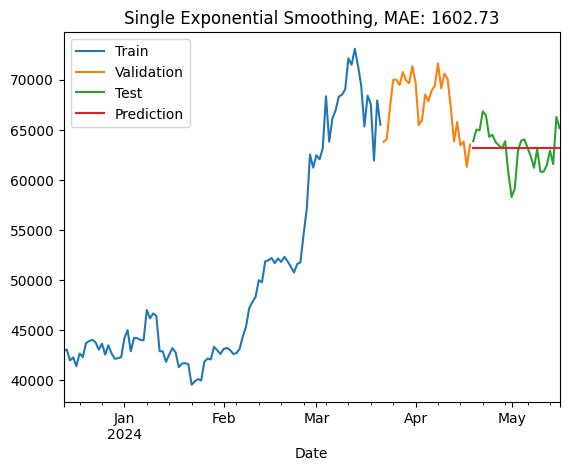

SSE      MAPE          MAD           MSD         RMSE       R2  \
0  1.179758e+08  2.559898  1602.734654  4.213421e+06  2052.661924 -0.00053   

   R2_adjusted  
0    -0.080572

In [ ]:
best_alpha, best_mae, y_pred = ses_model_tuning(train_data, validation_data, test_data)
ret1= measacc_fs(y_pred, test_data)
plot_model(train_data, validation_data, test_data, y_pred, title = "Single Exponential Smoothing")
ret1

In [ ]:
test_data.shape

(28,)

2493.476171940565 17.42403636025847


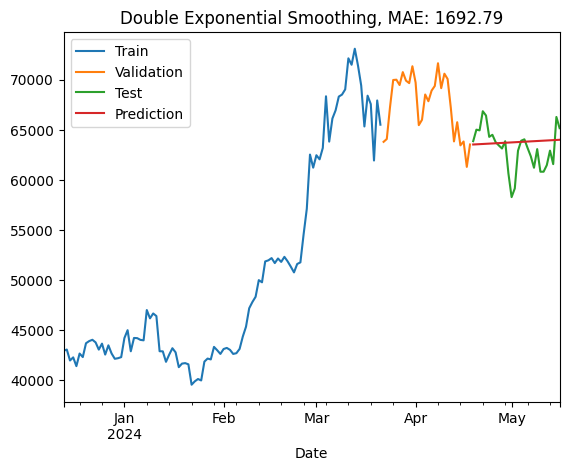

In [ ]:
btc_smooth1 = firstsmooth(pd.concat([train_data, validation_data]), lambda_=0.992)
btc_smooth2 = firstsmooth(btc_smooth1, lambda_=0.992)

lambda_ = 0.5
# lambda_ = 0.21000000000000002
# lambda_ = 0.11
C = lambda_/(1 - lambda_)
T = len(validation_data) + len(train_data)
beta_0 = (2 - T * C) * btc_smooth1[-1] - (1 - T * C) * btc_smooth2[-1]
beta_1 = C * (btc_smooth1[-1] - btc_smooth2[-1])
# double_exponation = lambda x: beta_0 + beta_1 * x
print(beta_0, beta_1)

def double_exponation_predict(start, end, beta_0, beta_1):
    y_pred = []
    for x in range(start, end):
        y_pred.append(beta_0 + beta_1 * x)
    return np.array(y_pred)

y_hat = double_exponation_predict(len(train_data) + len(validation_data), len(train_data) + len(validation_data) + len(test_data), beta_0, beta_1)

y_hat_test = test_data.copy()
y_hat_test[:] = y_hat

def plot_model(train, validation, test, y_pred, title):

    mae = mean_absolute_error(test, y_pred)
    train[-100:].plot(legend=True, label="Train", title=f"{title}, MAE: {round(mae, 2)}")
    validation.plot(legend=True, label="Validation")
    test.plot(legend=True, label="Test")
    y_pred.plot(legend=True, label="Prediction")
    plt.show()

plot_model(train_data, validation_data, test_data, y_hat_test, title = "Double Exponential Smoothing")

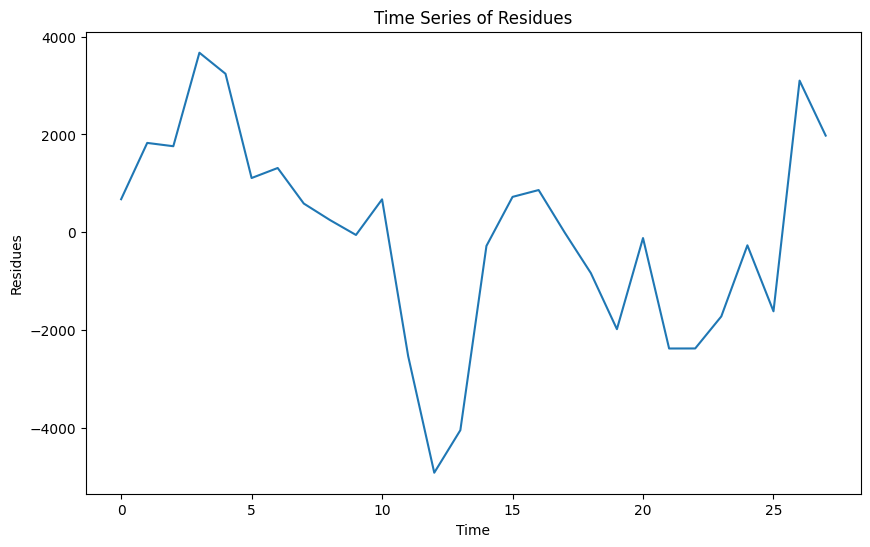

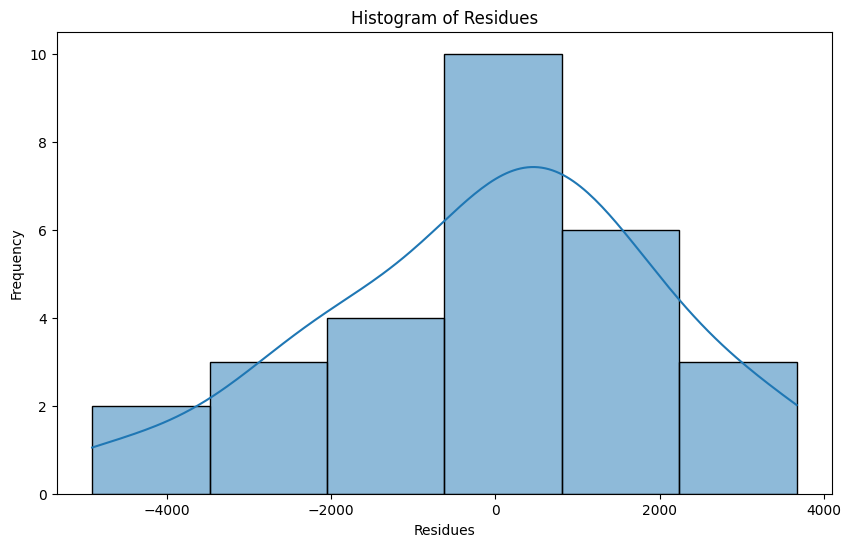

<Figure size 1000x600 with 0 Axes>

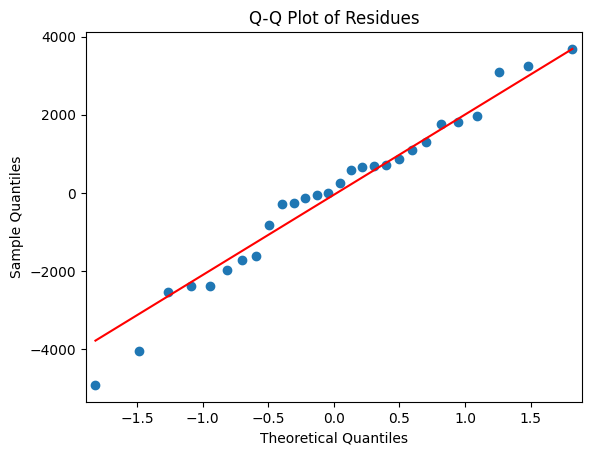

<Figure size 1000x600 with 0 Axes>

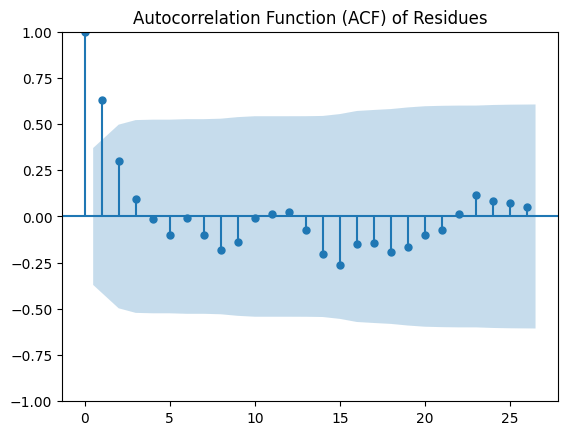

(array([  676.3673023 ,  1827.23839605,  1759.44152105,  3670.4766773 ,
         3240.0704273 ,  1109.6954273 ,  1314.50402105,   588.1173023 ,
          251.9376148 ,   -53.97254145,   673.91808355, -2530.34754145,
        -4913.19129145, -4043.76941645,  -277.3670727 ,   724.26964605,
          863.9298023 ,    -5.25379145,  -832.38660395, -1979.26160395,
         -117.2420727 , -2374.42566645, -2373.4920727 , -1718.80847895,
         -265.75379145, -1614.4139477 ,  3100.2891773 ,  1976.62902105]),
                                  Value
 MAPE                          0.025599
 RMSE                       2052.661924
 R2                           -0.000530
 Kurtosis (statistic)          0.252491
 Kurtosis (p-value)            0.800662
 Skewness (statistic)         -0.938224
 Skewness (p-value)            0.348129
 Jarque-Bera (statistic)       0.698163
 Jarque-Bera (p-value)         0.705336
 Dickey Fuller (statistic)    -2.825570
 Dickey Fuller (p-value)       0.054713
 KPSS test (st

In [ ]:
evaluate_model_residues(y_pred, test_data)

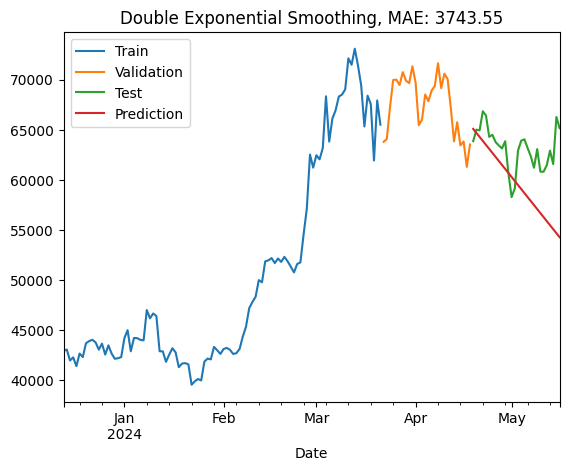

0.11 0.21000000000000002 2477.292242566313


SSE      MAPE         MAD           MSD         RMSE        R2  \
0  6.220018e+08  5.907931  3743.54594  2.221435e+07  4713.210309 -4.275078   

   R2_adjusted  
0    -4.697084

In [ ]:
def des_optimizer(train, validation, alphas, betas, trend):

    best_alpha, best_beta, best_mae = None, None, float("inf")

    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(len(validation))
            mae = mean_absolute_error(validation, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae

    return best_alpha, best_beta, best_mae

def des_model_tuning(train , validation, test, trend, title="Model Tuning - Double Exponential Smoothing"):

    alphas = np.arange(0.01, 1, 0.10)
    betas = np.arange(0.01, 1, 0.10)
    best_alpha, best_beta, best_mae = des_optimizer(train, validation, alphas, betas, trend=trend)
    final_model = ExponentialSmoothing(pd.concat([train, validation]), trend=trend).fit(smoothing_level=best_alpha, smoothing_slope=best_beta)
    y_pred = final_model.forecast(len(test))
    mae = mean_absolute_error(test, y_pred)

    # plot_model(train, test, y_pred, title)

    ret2= measacc_fs(y_pred, test_data)

    return best_alpha, best_beta, best_mae, y_pred


best_alpha, best_beta, best_mae, y_pred = des_model_tuning(train_data, validation_data, test_data, trend='add')
ret2= measacc_fs(y_pred, test_data)
plot_model(train_data, validation_data, test_data, y_pred, title = "Double Exponential Smoothing")
print(best_alpha, best_beta, best_mae)
ret2

In [ ]:
best_alpha, best_beta

(0.11, 0.21000000000000002)

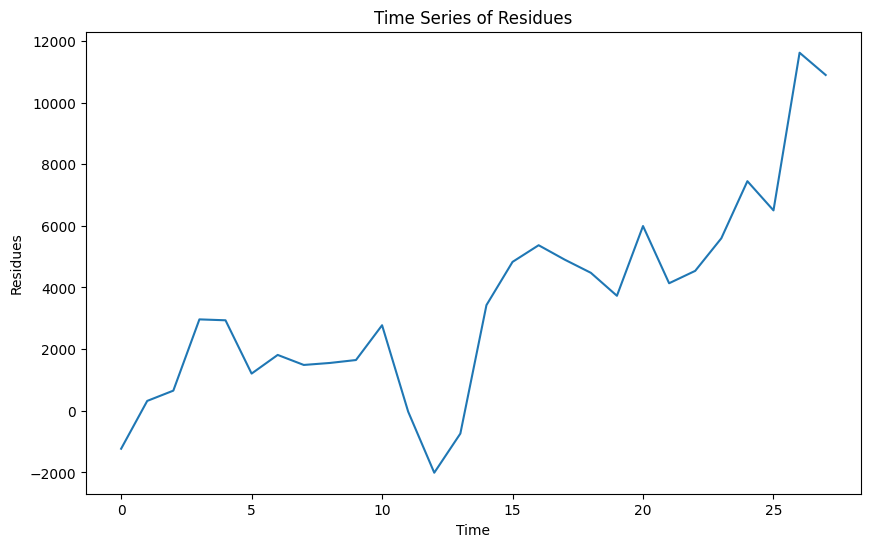

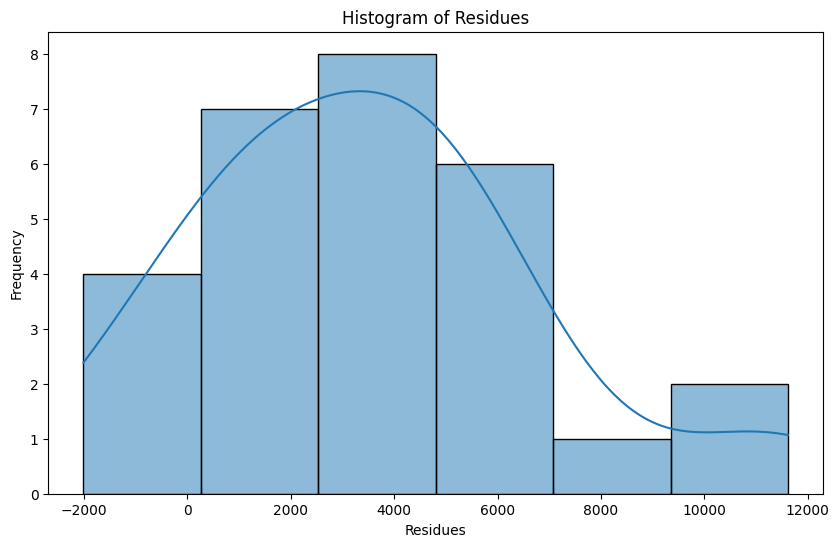

<Figure size 1000x600 with 0 Axes>

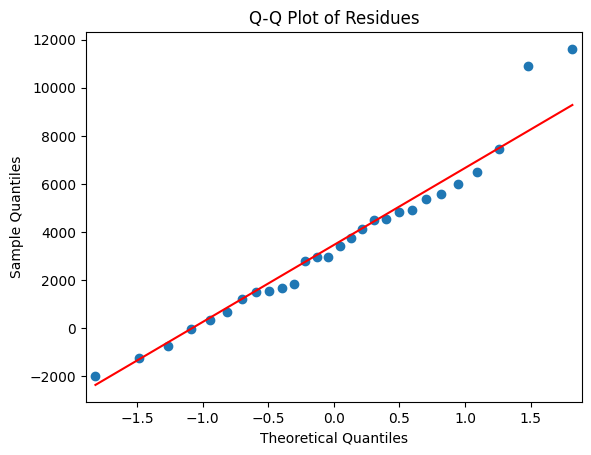

<Figure size 1000x600 with 0 Axes>

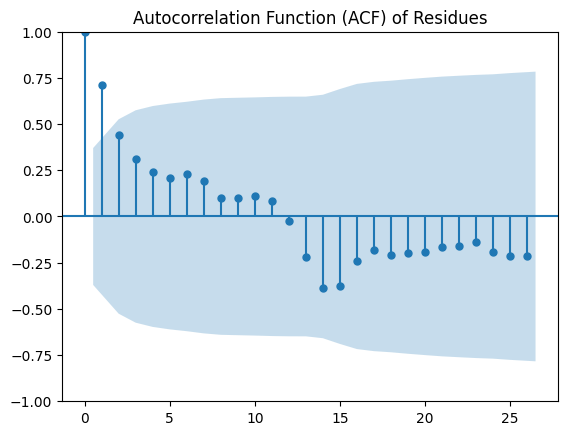

(array([-1232.23645429,   319.58980622,   652.74809798,  2964.73842099,
         2935.28733775,  1205.8675045 ,  1811.63126501,  1486.19971302,
         1550.97519228,  1646.02020279,  2774.86599455,   -28.44446369,
        -2010.33304693,  -739.95600518,  3427.40150533,  4829.99339084,
         5370.60871385,  4902.38028686,  4476.20264112,  3730.28280788,
         5993.25750589,  4137.02907889,  4538.9178394 ,  5594.55659991,
         7448.56645417,  6500.86146468, 11616.51975644, 10893.81476695]),
                                  Value
 MAPE                          0.059079
 RMSE                       4713.210309
 R2                           -4.275078
 Kurtosis (statistic)          0.985966
 Kurtosis (p-value)            0.324150
 Skewness (statistic)          1.618329
 Skewness (p-value)            0.105592
 Jarque-Bera (statistic)       2.255110
 Jarque-Bera (p-value)         0.323824
 Dickey Fuller (statistic)     0.489708
 Dickey Fuller (p-value)       0.984557
 KPSS test (st

In [ ]:
evaluate_model_residues(y_pred, test_data)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
p = q = range(0, 3)
d = range(0, 3)
pdq = list(itertools.product(p, d, q))
arima_results_btc = []
best_aic = float("inf")
best_param = None
for param_set in pdq:
    print(f'ARIMA{param_set}')
    try:
        arima_btc = ARIMA(train_data, order=param_set)
        arima_fitted_btc = arima_btc.fit()
        print(f'ARIMA{param_set} - AIC: {arima_fitted_btc.aic}')
        if arima_fitted_btc.aic < best_aic:
            best_aic = arima_fitted_btc.aic
            best_param = param_set
    except:
        print("An exception occurred:", sys.exc_info()[0])

print('**'*25)
print(f'Best ARIMA model: {best_param}')
print(f'Best AIC: {best_aic}')

ARIMA(0, 0, 0)
ARIMA(0, 0, 0) - AIC: 102403.4950175093
ARIMA(0, 0, 1)
ARIMA(0, 0, 1) - AIC: 72974.15393574338
ARIMA(0, 0, 2)
ARIMA(0, 0, 2) - AIC: 72026.20851120609
ARIMA(0, 1, 0)
ARIMA(0, 1, 0) - AIC: 56494.79438077772
ARIMA(0, 1, 1)
ARIMA(0, 1, 1) - AIC: 56488.19440478807
ARIMA(0, 1, 2)
ARIMA(0, 1, 2) - AIC: 56487.58867107766
ARIMA(0, 2, 0)
ARIMA(0, 2, 0) - AIC: 59054.3360269745
ARIMA(0, 2, 1)
ARIMA(0, 2, 1) - AIC: 56487.34819929866
ARIMA(0, 2, 2)
ARIMA(0, 2, 2) - AIC: 56480.554692351914
ARIMA(1, 0, 0)
ARIMA(1, 0, 0) - AIC: 56523.53778845111
ARIMA(1, 0, 1)
ARIMA(1, 0, 1) - AIC: 56515.150373933226
ARIMA(1, 0, 2)
ARIMA(1, 0, 2) - AIC: 56514.49366264172
ARIMA(1, 1, 0)
ARIMA(1, 1, 0) - AIC: 56487.76955900732
ARIMA(1, 1, 1)
ARIMA(1, 1, 1) - AIC: 56489.12377185726
ARIMA(1, 1, 2)
ARIMA(1, 1, 2) - AIC: 56482.25610960169
ARIMA(1, 2, 0)
ARIMA(1, 2, 0) - AIC: 57881.68037956255
ARIMA(1, 2, 1)
ARIMA(1, 2, 1) - AIC: 56480.028620318364
ARIMA(1, 2, 2)
ARIMA(1, 2, 2) - AIC: 56491.36176412254
ARIMA(2,

In [ ]:
arima_btc = ARIMA(pd.concat([train_data, validation_data]), order=best_param)
arima_fitted_btc = arima_btc.fit()

In [ ]:
arima_predictions_btc = arima_fitted_btc.predict(start=len(train_data) + len(validation_data),
end=len(train_data)\
+len(validation_data) + len(test_data) - 1,
dynamic=False)

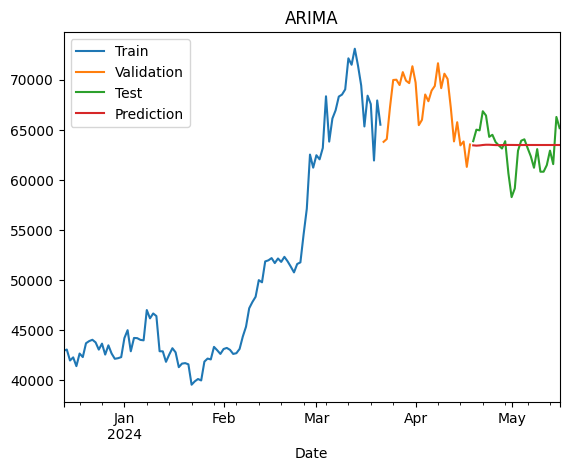

In [ ]:
def plot_model(train, validation, test, y_pred, title):

    train[-100:].plot(legend=True, label="Train", title=f"{title}")
    validation.plot(legend=True, label="Validation")
    test.plot(legend=True, label="Test")
    y_pred.plot(legend=True, label="Prediction")
    plt.show()

plot_model(train_data, validation_data, test_data, arima_predictions_btc, title = "ARIMA")

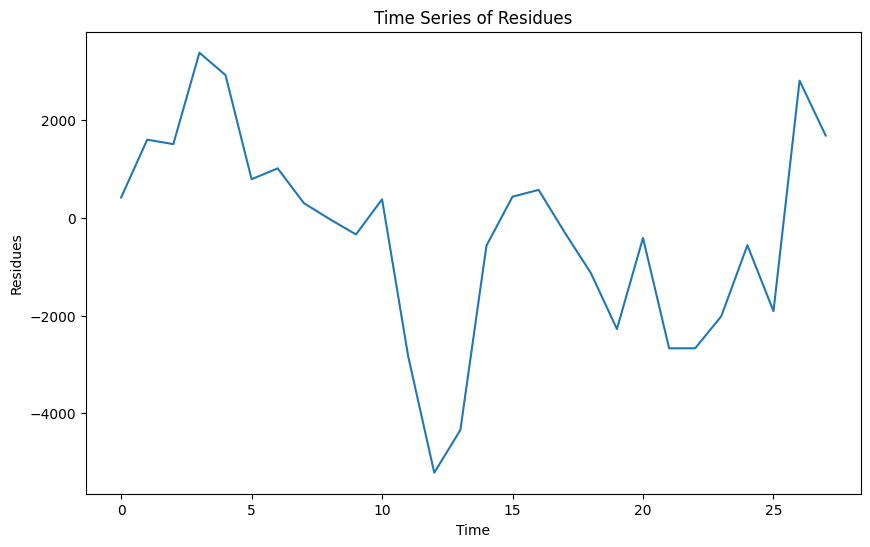

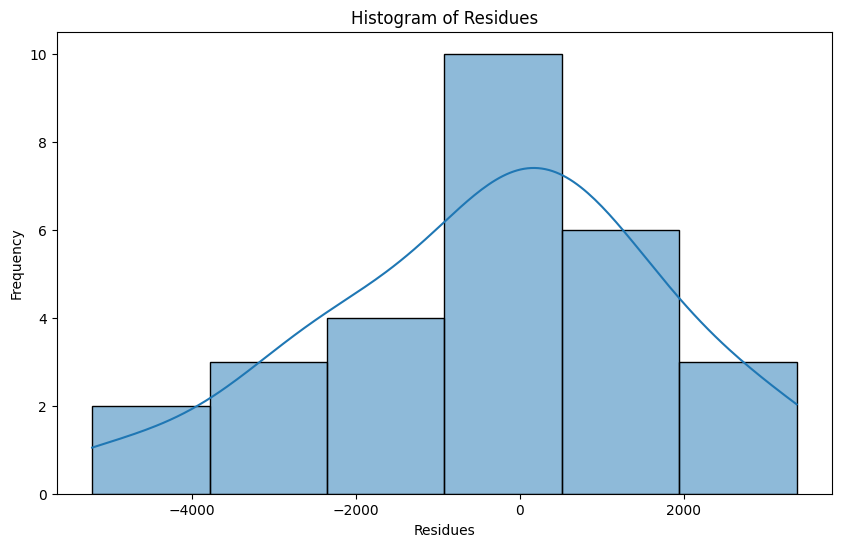

<Figure size 1000x600 with 0 Axes>

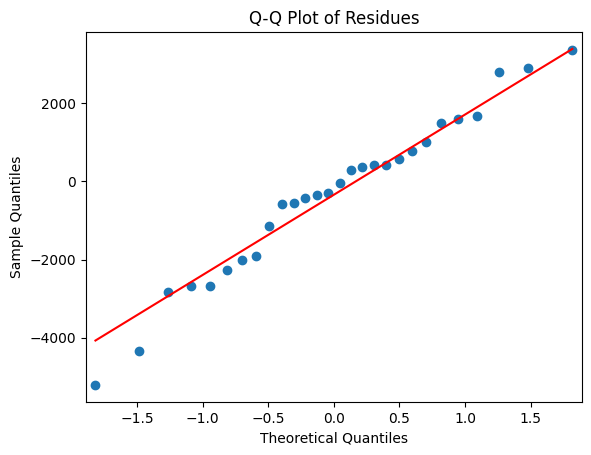

<Figure size 1000x600 with 0 Axes>

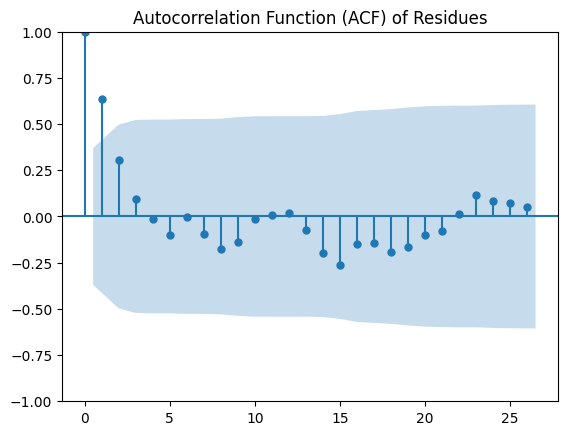

(array([  414.84902414,  1596.87413057,  1506.2164927 ,  3375.10462813,
         2917.96903107,   788.19456501,  1010.55915317,   300.97015379,
          -29.91749108,  -341.31280934,   377.85095518, -2831.4720094 ,
        -5213.72448782, -4340.51353305,  -570.77883791,   431.71327619,
          570.09500927,  -300.88257461, -1128.95927819, -2275.6190346 ,
         -412.78968033, -2669.31748453, -2668.25627824, -2013.86412179,
         -561.17562366, -1910.00909417,  2804.75690357,  1681.26829334]),
                                  Value
 MAPE                          0.025813
 RMSE                       2082.564279
 R2                           -0.029893
 Kurtosis (statistic)          0.240366
 Kurtosis (p-value)            0.810046
 Skewness (statistic)         -0.950828
 Skewness (p-value)            0.341692
 Jarque-Bera (statistic)       0.720176
 Jarque-Bera (p-value)         0.697615
 Dickey Fuller (statistic)    -2.816578
 Dickey Fuller (p-value)       0.055945
 KPSS test (st

In [ ]:
evaluate_model_residues(arima_predictions_btc, test_data)

In [ ]:
!pip install arch

In [ ]:
from arch import arch_model

[*********************100%%**********************]  1 of 1 completed


                       Zero Mean - GARCH Model Results                        
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -9293.47
Distribution:                  Normal   AIC:                           18598.9
Method:            Maximum Likelihood   BIC:                           18636.0
                                        No. Observations:                 3528
Date:                Mon, Jun 03 2024   Df Residuals:                     3528
Time:                        20:47:52   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.9061      0.320      2.833  4.615e-03   [  0.27

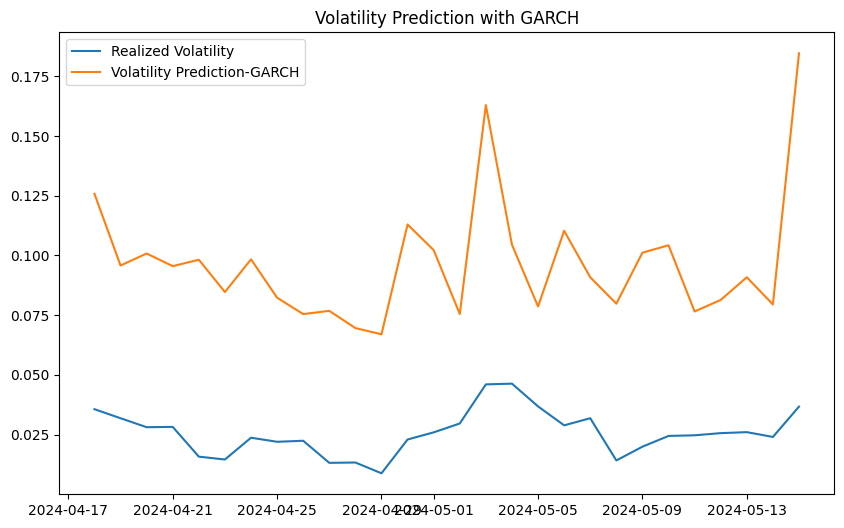

In [ ]:

import numpy as np
import yfinance as yf
import datetime as dt
from arch import arch_model
import matplotlib.pyplot as plt


def load_raw_data(ticker, start_date, end_date):
    price = yf.download(ticker, start_date, end_date)['Adj Close']
    ret = 100 * price.pct_change()[1:]
    ret.dropna(inplace=True)
    return ret


def model_train(ret, n=28):
    global garch, q, best_param
    bic_garch = []
    for p in range(1, 5):
        for q in range(1, 5):
            garch = arch_model(ret, mean='zero', vol='GARCH', p=p, o=0, q=q).fit(disp='off')
        bic_garch.append(garch.bic)
        if garch.bic == np.min(bic_garch):
            best_param = p, q
    garch = arch_model(ret, mean='zero', vol='GARCH', p=best_param[0], o=0, q=best_param[1]).fit(disp='off')
    print(garch.summary())

    realized_vol = ret.rolling(5).std()
    # n = 28
    split_date = ret.iloc[-n:].index
    forecast = garch.forecast(start=split_date[0])
    plt.figure(figsize=(10, 6))
    plt.plot(realized_vol[-28:] / 100, label='Realized Volatility')
    plt.plot(forecast.variance.iloc[-len(split_date):] / 100, label='Volatility Prediction-GARCH')
    plt.title('Volatility Prediction with GARCH')
    plt.legend()
    plt.show()

    return garch


ticker = 'BTC-USD'
start_date = dt.datetime(2014, 9, 17)
end_date = dt.datetime(2024,5, 16)
ret_ = load_raw_data(ticker, start_date, end_date)
garch_model_ = model_train(ret_)
forecasts = garch_model_.forecast(start=0)
# next_day_volatility = np.sqrt(forecasts.variance.iloc[-1, :] / 100)
# print(next_day_volatility)

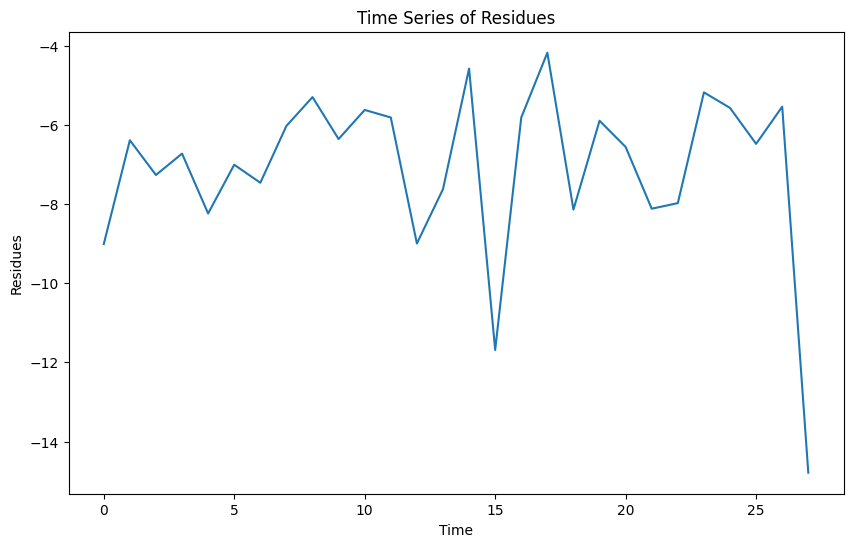

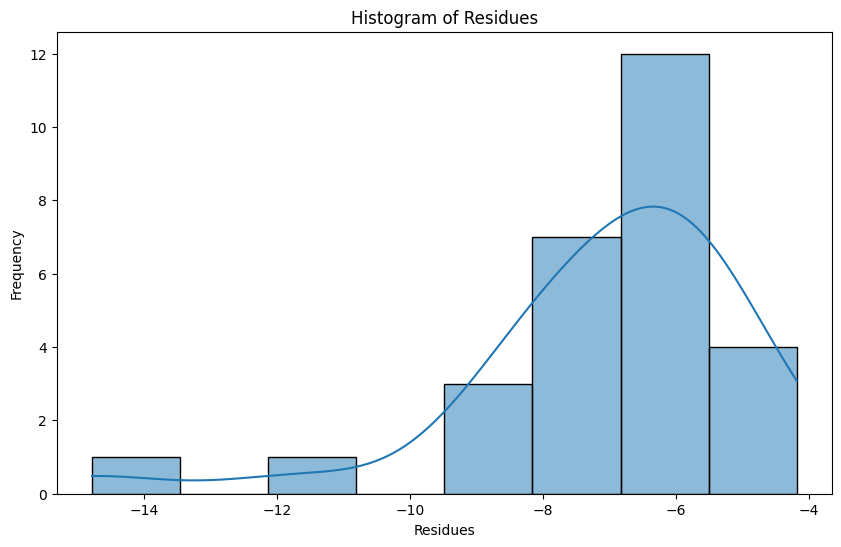

<Figure size 1000x600 with 0 Axes>

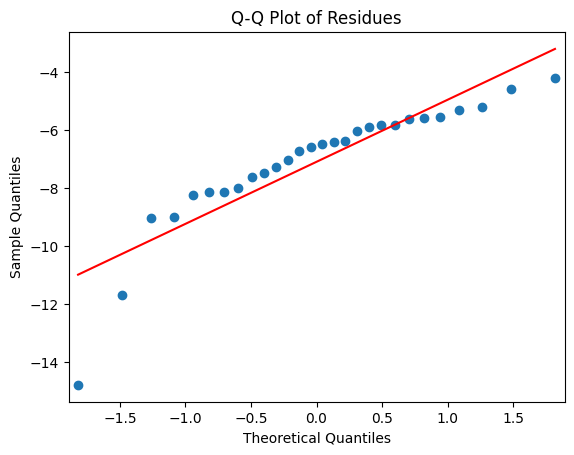

<Figure size 1000x600 with 0 Axes>

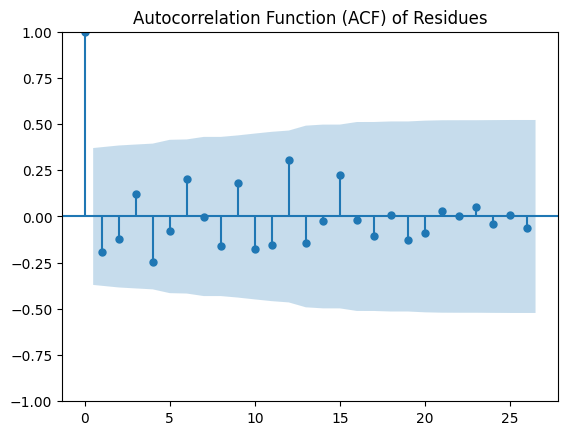

(array([ -9.01449303,  -6.3913477 ,  -7.2688469 ,  -6.72858551,
         -8.24090436,  -7.00918263,  -7.46519971,  -6.02990518,
         -5.3017815 ,  -6.36080884,  -5.62588262,  -5.81669205,
         -8.99932248,  -7.62659864,  -4.58230516, -11.68888574,
         -5.81655226,  -4.18093071,  -8.14235542,  -5.89809812,
         -6.56099768,  -8.12017604,  -7.97937095,  -5.18256122,
         -5.57481824,  -6.4824939 ,  -5.54403507, -14.78786645]),
                                   Value
 MAPE                       3.086398e+00
 RMSE                       7.403218e+00
 R2                        -6.516542e+01
 Kurtosis (statistic)       3.060178e+00
 Kurtosis (p-value)         2.212053e-03
 Skewness (statistic)      -3.631050e+00
 Skewness (p-value)         2.822701e-04
 Jarque-Bera (statistic)    3.463690e+01
 Jarque-Bera (p-value)      3.010876e-08
 Dickey Fuller (statistic) -5.271765e+00
 Dickey Fuller (p-value)    6.263321e-06
 KPSS test (statistic)      1.762144e-01
 KPSS test (p-val

In [ ]:
n = 28
y = ret_.rolling(5).std()[-n:]
split_date = ret_.iloc[-n:].index
forecast = garch.forecast(start=split_date[0])
y_pred = forecast.variance.iloc[-n:]
y_pred.shape, y.shape

evaluate_model_residues(y_pred, y)

## Deep Learning

In [ ]:
# !pip install ipdb

In [ ]:
# import ipdb

def create_windows(ts, window_size, train_steps, validation_steps, test_steps):
    #ipdb.set_trace()

    segment_size_ = window_size + train_steps + validation_steps + test_steps

    start = (len(ts)//segment_size_) * segment_size_

    ts0 = ts[-start:]

    Xtrains, ytrains, Xvalids, yvalids, Xtests, ytests = [], [], [], [], [], []

    i = 0
    while (len(ts0) - i + 1) >= segment_size_:
        X, y = [], []
        for _ in range(train_steps):
            X.append(ts0[i:i + window_size])
            y.append(ts0[i + window_size])
            i += 1
        Xtrains.append(X)
        ytrains.append(y)

        X, y = [], []
        for _ in range(validation_steps):
            X.append(ts0[i:i + window_size])
            y.append(ts0[i + window_size])
            i += 1
        Xvalids.append(X)
        yvalids.append(y)

        X, y = [], []
        for _ in range(test_steps):
            X.append(ts0[i:i + window_size])
            y.append(ts0[i + window_size])
            i += 1
        Xtests.append(X)
        ytests.append(y)

    return np.array(Xtrains), np.array(ytrains), np.array(Xvalids), np.array(yvalids), np.array(Xtests), np.array(ytests)

# ts = list(range(32))
# Xtr, ytr, Xval, yval, Xts, yts = create_windows(ts, 3, 4, 2, 2)
# print('Traing:')
# print(Xtr)
# print(ytr)
# print('Validation:')
# print(Xval)
# print(yval)
# print('Test:')
# print(Xts)
# print(yts)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import itertools

In [ ]:
# Function to calculate MAPE, RMSE, and R² adj
def calculate_metrics(y_true, y_pred, n, p):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    r2_adj = 1 - ((1 - r2) * (n - 1) / (n - p - 1))
    return mape, rmse, r2, r2_adj

# Function to evaluate the model and create a dataframe row
def evaluate_and_create_row(model, data_loader, criterion, scaler, window_size, model_name):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            all_predictions.append(outputs)
            all_targets.append(y_batch)

    # Concatenate all predictions and targets
    all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy()
    all_targets = torch.cat(all_targets, dim=0).cpu().numpy()

    all_predictions = scaler.inverse_transform(all_predictions.reshape(-1, 1))
    all_targets = scaler.inverse_transform(all_targets.reshape(-1, 1))

    n = len(all_targets)
    p = window_size
    mape, rmse, r2, r2_adj = calculate_metrics(np.concatenate(all_targets), np.concatenate(all_predictions), n, p)

    metrics_df = pd.DataFrame({
        'Model': [model_name],
        'MAPE': [mape],
        'RMSE': [rmse],
        'R²': [r2],
        'R² adj': [r2_adj]
    })

    return all_predictions, all_targets, metrics_df

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out)  # Apply fully connected layer to each time step
        return out

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
btc_close_scaled = scaler.fit_transform(btc.close.values.reshape(-1, 1))

# Convert to tensor
btc_close_tensor = torch.FloatTensor(btc_close_scaled).view(-1)

In [ ]:
window_sizes = [7, 14, 21, 28]
training_step_sizes = [7, 14, 21, 28]
# Define parameters

# Define the columns that will be in the metrics DataFrame
columns = ['Model', 'MAPE', 'RMSE', 'R²', 'R² adj']

# Create an empty DataFrame with the specified columns
lstm_result_df = pd.DataFrame(columns=columns)

for window_size, train_steps in itertools.product(window_sizes, training_step_sizes):
    # Create windows
    print(f'Window Size: {window_size}, Training Step Size: {train_steps}')


    validation_steps = 14
    test_steps = 14

    # Create windows
    Xtrains, ytrains, Xvalids, yvalids, Xtests, ytests = create_windows(btc_close_tensor, window_size, train_steps, validation_steps, test_steps)

    # Reshape the data to match the required input shape
    Xtrains = torch.tensor(Xtrains, dtype=torch.float32).view(-1, train_steps, window_size)
    ytrains = torch.tensor(ytrains, dtype=torch.float32).view(-1, train_steps, 1)
    Xvalids = torch.tensor(Xvalids, dtype=torch.float32).view(-1, validation_steps, window_size)
    yvalids = torch.tensor(yvalids, dtype=torch.float32).view(-1, validation_steps, 1)
    Xtests = torch.tensor(Xtests, dtype=torch.float32).view(-1, test_steps, window_size)
    ytests = torch.tensor(ytests, dtype=torch.float32).view(-1, test_steps, 1)


    train_dataset = TensorDataset(Xtrains, ytrains)
    valid_dataset = TensorDataset(Xvalids, yvalids)
    test_dataset = TensorDataset(Xtests, ytests)

    # batch_size = Xtrains.shape[0]  # Ensure batch_size matches the first dimension of Xtrains
    batch_size = 1
    train_loader_original = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


    # Model Parameters
    input_size = window_size
    hidden_size = 25
    output_size = 1
    num_layers = 6

    model = LSTMModel(input_size, hidden_size, output_size, num_layers)

    # Training parameters
    num_epochs = 100
    learning_rate = 0.001

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Zero out the gradients for the next batch
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimize the weights
            epoch_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            avg_loss = epoch_loss / len(train_loader)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

    model_name = f'lstm_model_{window_size}_{train_steps}.pth'

    _, _, valid_metrics_df = evaluate_and_create_row(model, valid_loader, criterion, scaler, window_size, model_name)

    print(valid_metrics_df)

    lstm_result_df = pd.concat([lstm_result_df, valid_metrics_df], ignore_index=True)

    torch.save({
        'input_size': input_size,
        'hidden_size': hidden_size,
        'output_size': output_size,
        'num_layers': num_layers,
        'state_dict': model.state_dict(),
        'test_loader': test_loader
    }, model_name)
    print("Model saved successfully!")

Window Size: 7, Training Step Size: 7
Epoch [10/100], Loss: 0.0014
Epoch [20/100], Loss: 0.0011
Epoch [30/100], Loss: 0.0007
Epoch [40/100], Loss: 0.0008
Epoch [50/100], Loss: 0.0008
Epoch [60/100], Loss: 0.0008
Epoch [70/100], Loss: 0.0007
Epoch [80/100], Loss: 0.0008
Epoch [90/100], Loss: 0.0008
Epoch [100/100], Loss: 0.0006
                Model       MAPE         RMSE        R²    R² adj
0  lstm_model_7_7.pth  43.144879  3004.210938  0.971116  0.970971
Model saved successfully!
Window Size: 7, Training Step Size: 14
Epoch [10/100], Loss: 0.0041
Epoch [20/100], Loss: 0.0063
Epoch [30/100], Loss: 0.0025
Epoch [40/100], Loss: 0.0019
Epoch [50/100], Loss: 0.0025
Epoch [60/100], Loss: 0.0021
Epoch [70/100], Loss: 0.0015
Epoch [80/100], Loss: 0.0011
Epoch [90/100], Loss: 0.0015
Epoch [100/100], Loss: 0.0028
                 Model       MAPE         RMSE        R²    R² adj
0  lstm_model_7_14.pth  30.207747  3448.682861  0.961483  0.961249
Model saved successfully!
Window Size: 7, Trainin

In [ ]:
lstm_result_df

Model       MAPE         RMSE        R²    R² adj
0  lstm_model_14_28.pth  70.378596  3091.193359  0.970714  0.970233
1  lstm_model_21_28.pth  78.875804  3494.796631  0.961804  0.960840

In [ ]:
model_with_min_r2_adj = lstm_result_df.loc[lstm_result_df['R² adj'].idxmin(), 'Model']
print(f"Model with the smallest R² adjusted: {model_with_min_r2_adj}")

checkpoint = torch.load(model_with_min_r2_adj)

input_size = checkpoint['input_size']
hidden_size = checkpoint['hidden_size']
output_size = checkpoint['output_size']
num_layers = checkpoint['num_layers']
test_loader = checkpoint['test_loader']

lstm_model = LSTMModel(input_size, hidden_size, output_size, num_layers)

lstm_model.load_state_dict(checkpoint['state_dict'])
print("Model loaded successfully!")

Model with the smallest R² adjusted: lstm_model_7_14.pth
Model loaded successfully!


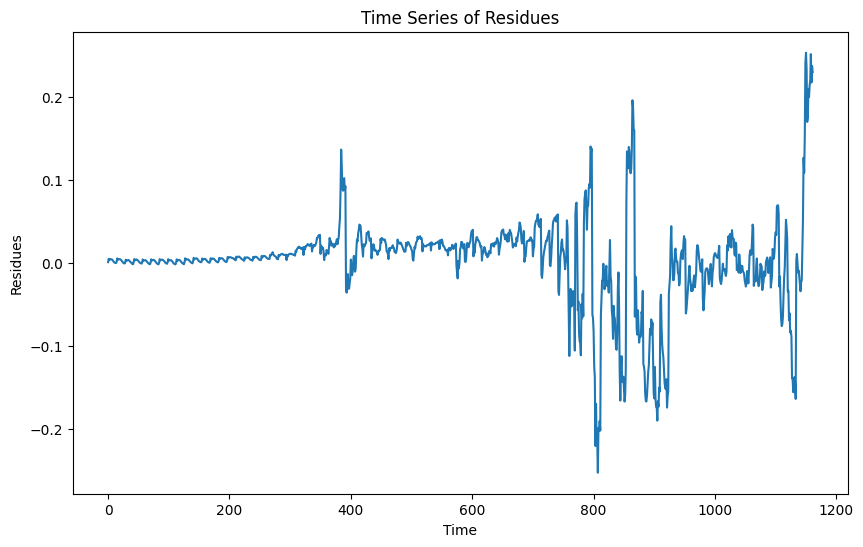

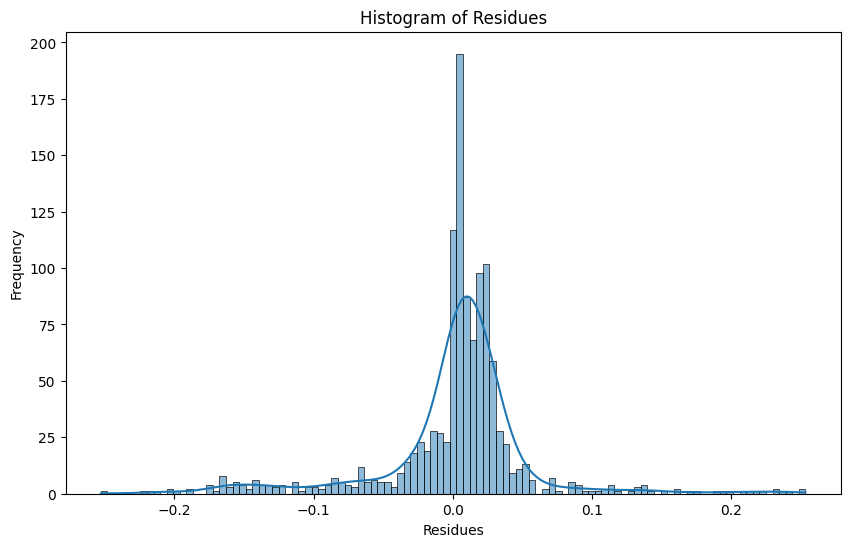

<Figure size 1000x600 with 0 Axes>

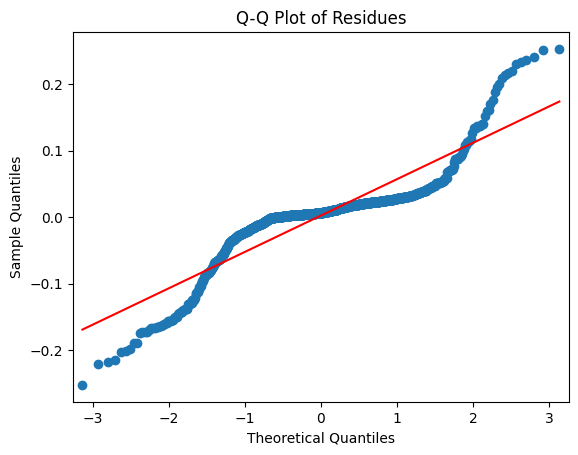

<Figure size 1000x600 with 0 Axes>

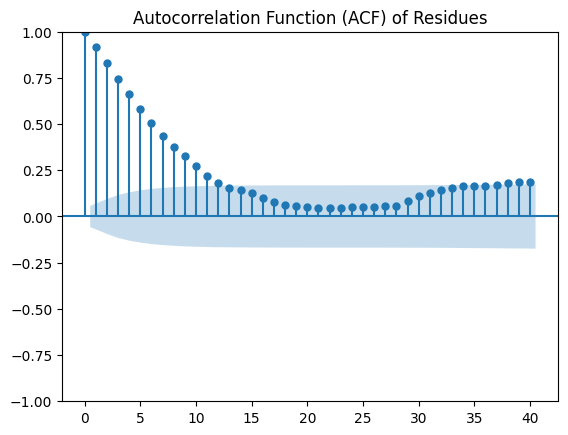

Value
MAPE                       5.435832e-01
RMSE                       5.480535e-02
R2                         9.483267e-01
Kurtosis (statistic)       1.215134e+01
Kurtosis (p-value)         5.643074e-34
Skewness (statistic)      -6.034041e+00
Skewness (p-value)         1.599099e-09
Jarque-Bera (statistic)    1.569280e+03
Jarque-Bera (p-value)      0.000000e+00
Dickey Fuller (statistic) -5.324036e+00
Dickey Fuller (p-value)    4.881598e-06
KPSS test (statistic)      5.052127e-01
KPSS test (p-value)        4.049264e-02

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_adjusted_r2(all_targets, all_predictions, model):
    n = len(all_targets)
    k = count_parameters(model)  # Total number of trainable parameters

    r2 = r2_score(all_targets, all_predictions)
    r2_adj = 1 - (1 - r2) * (n - 1) / (n - k - 1)

    print(f"R²: {r2:.4f}")
    print(f"R² adjusted: {r2_adj:.4f}")
    print(f"Number of trainable parameters: {k}")
    print(f"Nunmber of measures : {n}")

    return r2_adj

def evaluate_model_residues(model, data_loader, criterion):
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            all_predictions.append(outputs)
            all_targets.append(y_batch)

    # Concatenate all predictions and targets
    all_predictions = torch.cat(all_predictions, dim=0).cpu().numpy().reshape(-1)
    all_targets = torch.cat(all_targets, dim=0).cpu().numpy().reshape(-1)

    residues = all_targets - all_predictions

    # Calculate statistics
    mape = mean_absolute_percentage_error(all_targets, all_predictions)
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    r2 = r2_score(all_targets, all_predictions)

    kurt_stat, kurt_p_value = kurtosistest(residues)
    skew_stat, skew_p_value = skewtest(residues)
    jb_stat, jb_p_value = jarque_bera(residues)
    adf_stat, adf_p_value, _, _, _, _ = adfuller(residues)
    kpss_stat, kpss_p_value, _, _ = kpss(residues)

    results = {
        'MAPE': mape,
        'RMSE': rmse,
        # 'R2 adj': r2_adj,
        'R2': r2,
        'Kurtosis (statistic)': kurt_stat,
        'Kurtosis (p-value)': kurt_p_value,
        'Skewness (statistic)': skew_stat,
        'Skewness (p-value)': skew_p_value,
        'Jarque-Bera (statistic)': jb_stat,
        'Jarque-Bera (p-value)': jb_p_value,
        'Dickey Fuller (statistic)': adf_stat,
        'Dickey Fuller (p-value)': adf_p_value,
        'KPSS test (statistic)': kpss_stat,
        'KPSS test (p-value)': kpss_p_value
    }

    results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

    # Plotting the time series of residues
    plt.figure(figsize=(10, 6))
    plt.plot(residues)
    plt.title('Time Series of Residues')
    plt.xlabel('Time')
    plt.ylabel('Residues')
    plt.show()

    # Plotting the histogram of residues
    plt.figure(figsize=(10, 6))
    sns.histplot(residues, kde=True)
    plt.title('Histogram of Residues')
    plt.xlabel('Residues')
    plt.ylabel('Frequency')
    plt.show()

    # Q-Q plot of residues
    plt.figure(figsize=(10, 6))
    sm.qqplot(residues, line='s')
    plt.title('Q-Q Plot of Residues')
    plt.show()

    # ACF plot of residues
    plt.figure(figsize=(10, 6))
    sm.graphics.tsa.plot_acf(residues, lags=40)
    plt.title('Autocorrelation Function (ACF) of Residues')
    plt.show()

    return residues, results_df

residues, results_df = evaluate_model_residues(lstm_model, test_loader, criterion)
results_df

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [ ]:
window_sizes = [7, 14, 21, 28]
training_step_sizes = [7, 14, 21, 28]

columns = ['Model', 'MAPE', 'RMSE', 'R²', 'R² adj']

mlp_result_df = pd.DataFrame(columns=columns)

for window_size, train_steps in itertools.product(window_sizes, training_step_sizes):
    validation_steps = 14
    test_steps = 14

    Xtrains, ytrains, Xvalids, yvalids, Xtests, ytests = create_windows(btc_close_tensor, window_size, train_steps, validation_steps, test_steps)

    Xtrains = torch.tensor(Xtrains, dtype=torch.float32).view(-1, train_steps, window_size)
    ytrains = torch.tensor(ytrains, dtype=torch.float32).view(-1, train_steps, 1)
    Xvalids = torch.tensor(Xvalids, dtype=torch.float32).view(-1, validation_steps, window_size)
    yvalids = torch.tensor(yvalids, dtype=torch.float32).view(-1, validation_steps, 1)
    Xtests = torch.tensor(Xtests, dtype=torch.float32).view(-1, test_steps, window_size)
    ytests = torch.tensor(ytests, dtype=torch.float32).view(-1, test_steps, 1)


    train_dataset = TensorDataset(Xtrains, ytrains)
    valid_dataset = TensorDataset(Xvalids, yvalids)
    test_dataset = TensorDataset(Xtests, ytests)

    batch_size = 1
    train_loader_original = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_size = window_size  # Each feature is a single value (univariate time series)
    hidden_size = 50
    output_size = 1

    model = MLPModel(input_size, hidden_size, output_size)

    num_epochs = 100
    learning_rate = 0.001

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()  # Zero out the gradients for the next batch
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimize the weights
            epoch_loss += loss.item()

        if (epoch + 1) % 10 == 0:
            avg_loss = epoch_loss / len(train_loader)
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

    model_name = f'mlp_model_{window_size}_{train_steps}.pth'

    _, _, valid_metrics_df = evaluate_and_create_row(model, valid_loader, criterion, scaler, window_size, model_name)

    print(valid_metrics_df)

    mlp_result_df = pd.concat([mlp_result_df, valid_metrics_df], ignore_index=True)

    torch.save({
        'input_size': input_size,
        'hidden_size': hidden_size,
        'output_size': output_size,
        'num_layers': num_layers,
        'test_loader': test_loader,
        'state_dict': model.state_dict()
    }, model_name)

Epoch [10/100], Loss: 0.0002
Epoch [20/100], Loss: 0.0008
Epoch [30/100], Loss: 0.0005
Epoch [40/100], Loss: 0.0002
Epoch [50/100], Loss: 0.0002
Epoch [60/100], Loss: 0.0005
Epoch [70/100], Loss: 0.0002
Epoch [80/100], Loss: 0.0002
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0002
               Model       MAPE        RMSE        R²    R² adj
0  mlp_model_7_7.pth  40.628487  1105.81604  0.996087  0.996067
Epoch [10/100], Loss: 0.0004
Epoch [20/100], Loss: 0.0003
Epoch [30/100], Loss: 0.0003
Epoch [40/100], Loss: 0.0003
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0002
Epoch [80/100], Loss: 0.0002
Epoch [90/100], Loss: 0.0002
Epoch [100/100], Loss: 0.0003
                Model       MAPE        RMSE        R²    R² adj
0  mlp_model_7_14.pth  61.009562  1133.64917  0.995838  0.995813
Epoch [10/100], Loss: 0.0004
Epoch [20/100], Loss: 0.0002
Epoch [30/100], Loss: 0.0004
Epoch [40/100], Loss: 0.0002
Epoch [50/100], Loss: 0.0004
Epoch [60/100],

In [ ]:
mlp_result_df

Model        MAPE         RMSE        R²    R² adj
0     mlp_model_7_7.pth   40.628487  1105.816040  0.996087  0.996067
1    mlp_model_7_14.pth   61.009562  1133.649170  0.995838  0.995813
2    mlp_model_7_21.pth   28.870946   980.289001  0.996824  0.996801
3    mlp_model_7_28.pth   27.324271   955.654114  0.996959  0.996934
4    mlp_model_14_7.pth   11.440194  1068.450562  0.996416  0.996380
5   mlp_model_14_14.pth   16.532524  1140.142090  0.995790  0.995739
6   mlp_model_14_21.pth   45.052978  1084.413574  0.996134  0.996079
7   mlp_model_14_28.pth  292.689967  2994.274170  0.972522  0.972071
8    mlp_model_21_7.pth   17.212278  1446.284546  0.993508  0.993409
9   mlp_model_21_14.pth   15.817231  1244.857300  0.994984  0.994892
10  mlp_model_21_21.pth    6.751448  1162.640503  0.995889  0.995801
11  mlp_model_21_28.pth   16.166444  1090.275146  0.996283  0.996189
12   mlp_model_28_7.pth   15.141301  1581.700806  0.992205  0.992046
13  mlp_model_28_14.pth    8.085906  1357.733154  0.994045  0.993896
14  mlp_model_28_21.pth   12.930071  1157.066772  0.995873  0.995752
15  mlp_model_28_28.pth    9.361023  1462.948608  0.993285  0.993061

Model with the smallest R² adjusted: mlp_model_14_28.pth
Model loaded successfully!


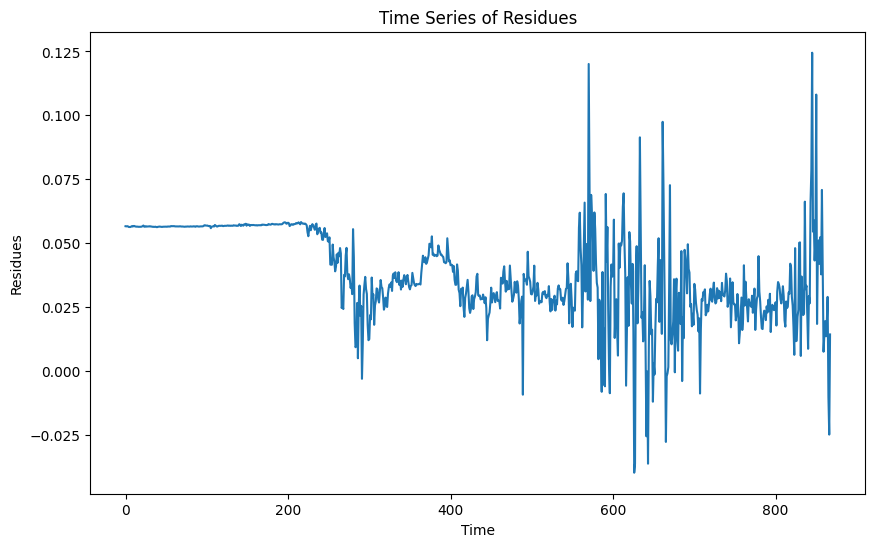

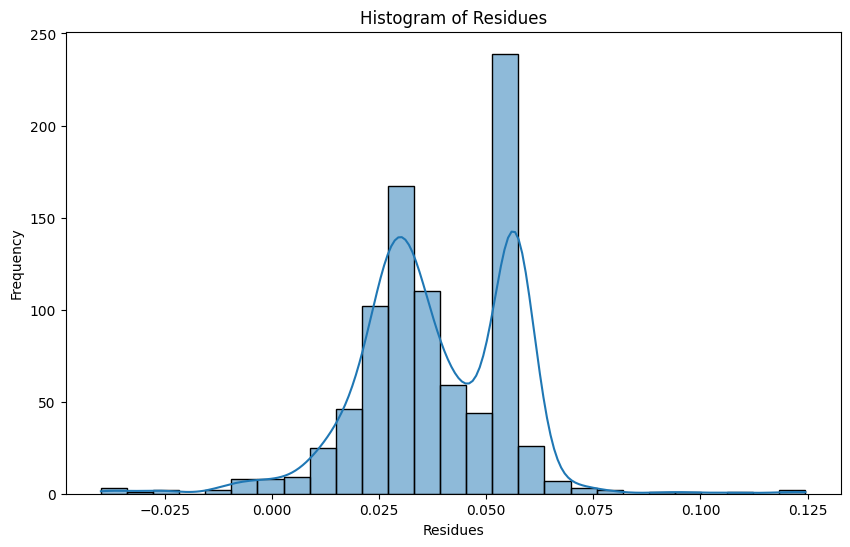

<Figure size 1000x600 with 0 Axes>

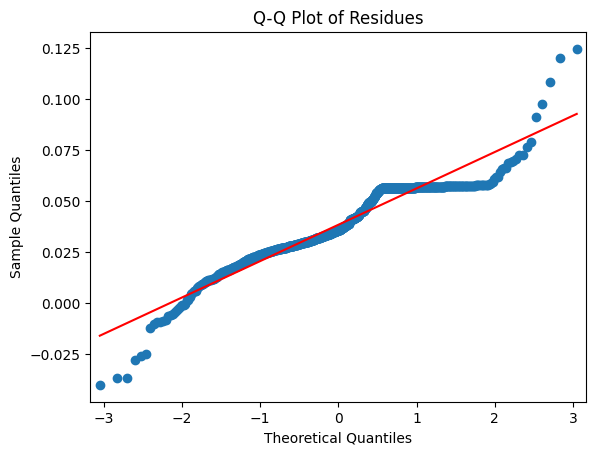

<Figure size 1000x600 with 0 Axes>

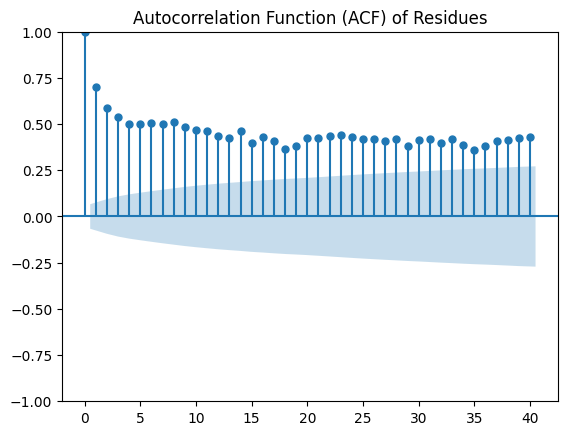

Value
MAPE                       8.169325e+00
RMSE                       4.234331e-02
R2                         9.703947e-01
Kurtosis (statistic)       6.719477e+00
Kurtosis (p-value)         1.823781e-11
Skewness (statistic)      -3.081557e+00
Skewness (p-value)         2.059207e-03
Jarque-Bera (statistic)    1.635853e+02
Jarque-Bera (p-value)      3.005369e-36
Dickey Fuller (statistic) -2.614958e+00
Dickey Fuller (p-value)    8.994495e-02
KPSS test (statistic)      3.280147e+00
KPSS test (p-value)        1.000000e-02

In [ ]:
# Identify the model with the smallest R² adjusted value
model_with_min_r2_adj = mlp_result_df.loc[mlp_result_df['R² adj'].idxmin(), 'Model']
print(f"Model with the smallest R² adjusted: {model_with_min_r2_adj}")

checkpoint = torch.load(model_with_min_r2_adj)

input_size = checkpoint['input_size']
hidden_size = checkpoint['hidden_size']
output_size = checkpoint['output_size']
num_layers = checkpoint['num_layers']
test_loader = checkpoint['test_loader']

mlp_model = MLPModel(input_size, hidden_size, output_size)

mlp_model.load_state_dict(checkpoint['state_dict'])
print("Model loaded successfully!")

residues, results_df = evaluate_model_residues(mlp_model, test_loader, criterion)
results_df

In [ ]:
test_predictions, test_targets, test_metrics_df = evaluate_and_create_row(mlp_model, test_loader, criterion, scaler, window_size, "MLP")

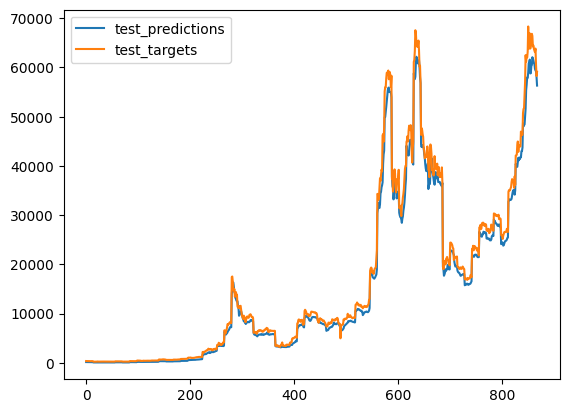

Model       MAPE         RMSE        R²    R² adj
0   MLP  21.697628  1892.736328  0.988871  0.988595

In [ ]:
# Plot train_predictions train_targets
plt.plot(test_predictions.reshape(-1), label='test_predictions')
plt.plot(test_targets.reshape(-1), label='test_targets')
plt.legend()
plt.show()
test_metrics_df